<a href="https://colab.research.google.com/github/chocochip13/epilepsy-eeg/blob/main/eeg_eda_20241120_clean_test_final_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Libraries

In [ ]:
! apt-get install -y xvfb
! pip install mne PyWavelets reportlab nilearn autoreject

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# Load Libraries

In [ ]:
import mne
from mne.preprocessing import ICA
from mne import create_info, make_fixed_length_events
from mne.io import RawArray
from mne.epochs import Epochs
from mne.time_frequency import psd_array_multitaper

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.signal import find_peaks, welch, coherence
from scipy.stats import norm, entropy

import pywt

from datetime import datetime
import os
from pathlib import Path
from collections import Counter
import pickle
import io
import sys
import warnings
import logging

import networkx as nx
from autoreject import AutoReject


### Load Raw data

In [ ]:
# Define the file path
#file_path = '/content/drive/MyDrive/FLUW/bogac/'
file_path = '/content/'
current_date = datetime.now().strftime('%Y%m%d')
report_file_path = file_path + f'report{current_date}/'
data_path = file_path + 'data/'

# Create directory if it doesn't exist
if not os.path.exists(report_file_path):
    os.makedirs(report_file_path)

# Load the raw data
raw = mne.io.read_raw_edf(data_path + '02_DNEW0000.edf', preload=True, encoding='latin1')

Extracting EDF parameters from /content/data/02_DNEW0000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-3-c45cb8d60a2c>:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_path + '02_DNEW0000.edf', preload=True, encoding='latin1')
<ipython-input-3-c45cb8d60a2c>:13: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_path + '02_DNEW0000.edf', preload=True, encoding='latin1')


Reading 0 ... 118499  =      0.000 ...   473.996 secs...


## Plot Raw Data

Using matplotlib as 2D backend.


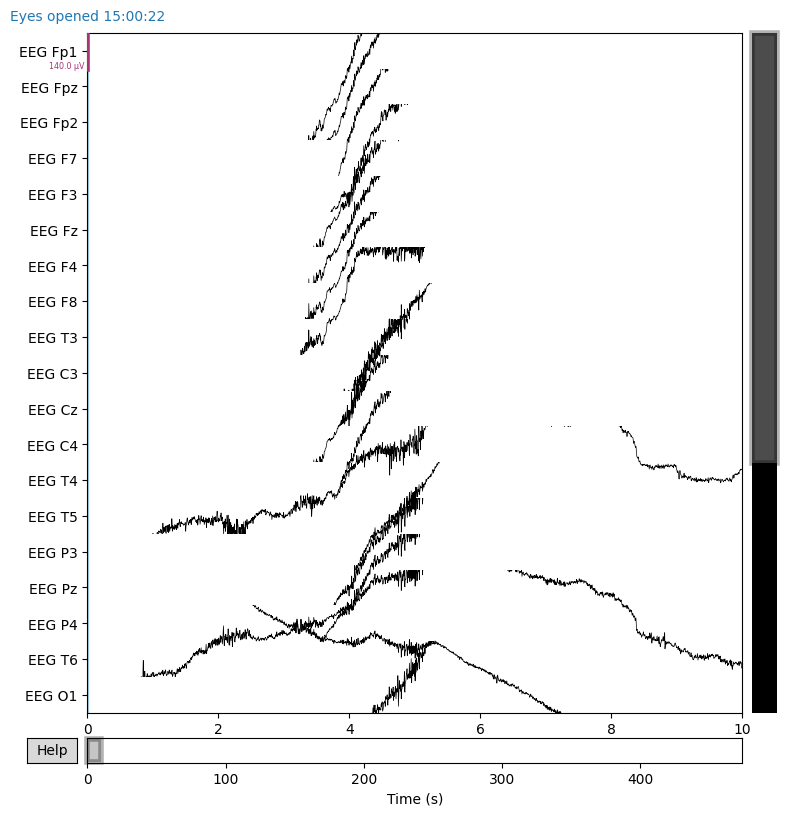

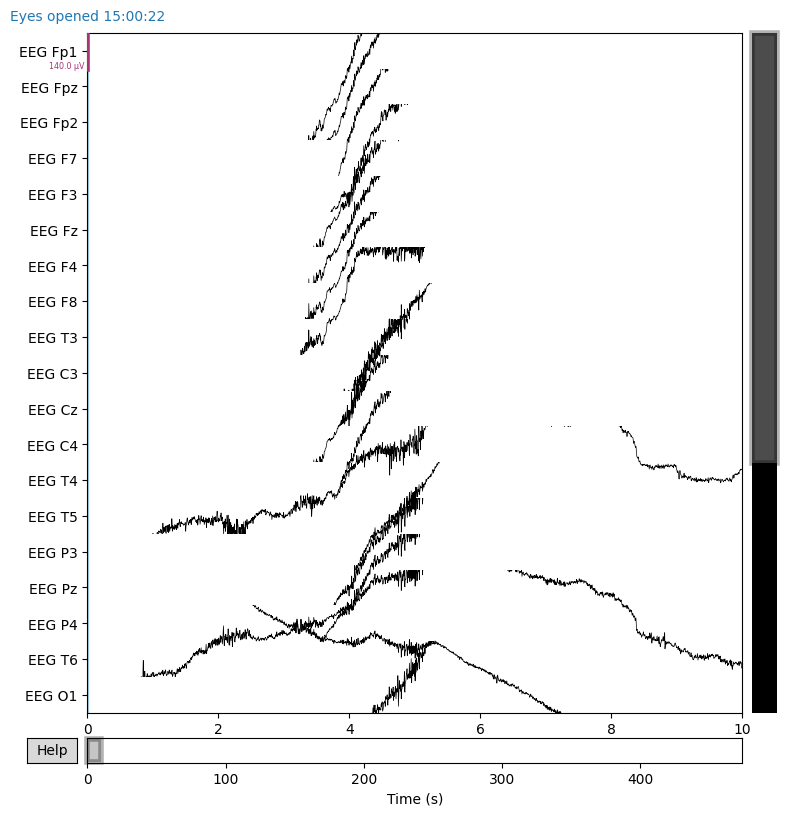

In [ ]:
raw.plot(n_channels=19, scalings=70e-6)

In [ ]:
channel_names = raw.info['ch_names']
print(channel_names)

mapping = {ch: ch.replace('EEG ', '') for ch in raw.info['ch_names'] if 'EEG ' in ch}
raw.rename_channels(mapping)

# Step 1.2: Set non-EEG channels (e.g., ECG, Bio channels)
non_eeg_channels = ['Bio1-2', 'Bio3-4', 'ECG', 'Bio4', 'VSyn', 'ASyn', 'LABEL']
raw.set_channel_types({ch: 'misc' for ch in non_eeg_channels})


desired_channels = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
    'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
    'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'
]
raw.pick_channels(desired_channels)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


['EEG Fp1', 'EEG Fpz', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG Fz', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG Pz', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG Oz', 'EEG O2', 'Bio1-2', 'Bio3-4', 'ECG', 'Bio4', 'A1', 'A2', 'VSyn', 'ASyn', 'LABEL']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-5-5f37db0c4f4f>:9: RuntimeWarning: The unit for channel(s) ASyn, Bio1-2, Bio3-4, Bio4, ECG, LABEL, VSyn has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in non_eeg_channels})


<RawEDF | 02_DNEW0000.edf, 19 x 118500 (474.0 s), ~17.2 MB, data loaded>

## Raw plot with proper channel names

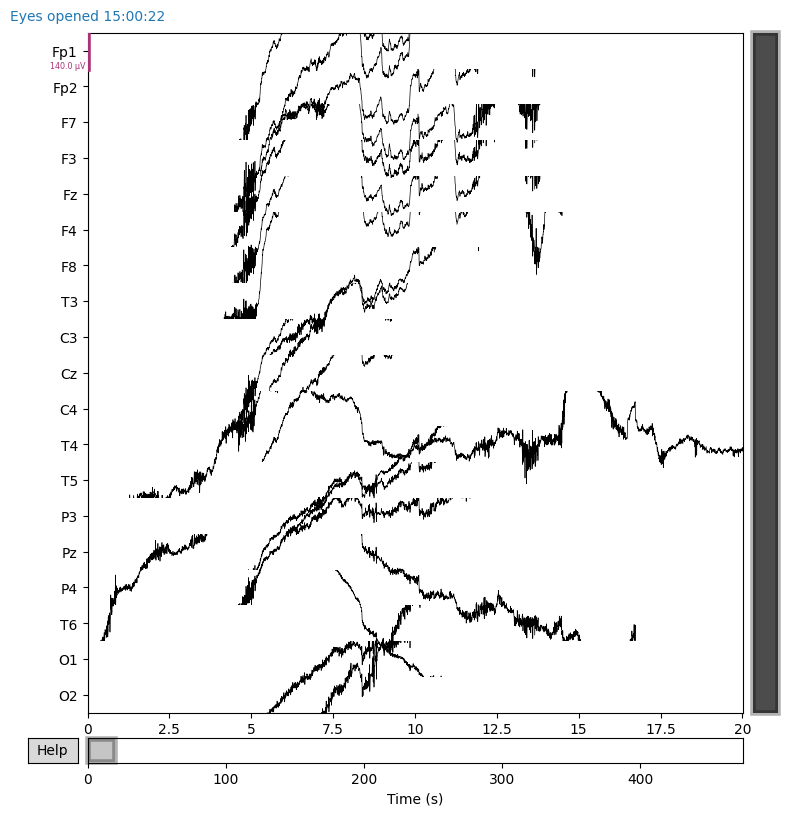

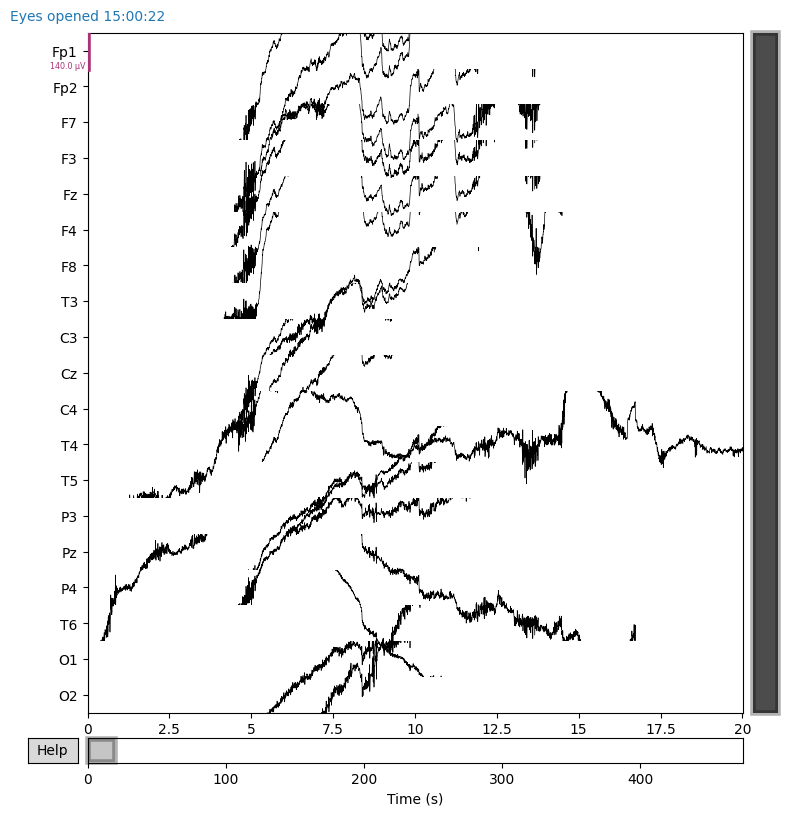

In [ ]:
raw.plot(n_channels=19, duration = 20, scalings=70e-6)


## Remove first and last 10

In [ ]:
# Define the duration to remove (in seconds)
remove_duration = 10  # seconds

# Define the sampling frequency of your data
sampling_frequency = raw.info['sfreq']  # Get sampling frequency from the raw object

# Calculate the number of samples to remove
samples_to_remove = int(remove_duration * sampling_frequency)

# Get the total number of samples in the raw data
total_samples = raw.n_times

# Check if the total samples are sufficient
if total_samples > 2 * samples_to_remove:
    # Trim the raw data
    trimmed_data = raw.copy().crop(tmin=samples_to_remove / sampling_frequency,
                                            tmax=(total_samples - samples_to_remove) / sampling_frequency)

    # Optionally, you can update cleaned_raw with the trimmed data
    raw = trimmed_data
else:
    print("Not enough data to remove the specified duration.")

# Print new data info
print(f"New data length: {raw.n_times} samples, "
      f"Duration: {raw.times[-1] - raw.times[0]:.2f} seconds")


New data length: 113501 samples, Duration: 454.00 seconds


In [ ]:
raw.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


<RawEDF | 02_DNEW0000.edf, 19 x 113501 (454.0 s), ~16.5 MB, data loaded>

In [ ]:
def preprocess_continuous(raw, variance_threshold = 3.0):
    # Preprocessing: Filter and re-reference
    raw.filter(l_freq=1.0, h_freq=40.0)
    raw.set_eeg_reference('average', projection=True)
    print("Starting AutoReject...")

    # Create fixed-length events (if no events exist in the dataset)
    events = make_fixed_length_events(raw, duration=2.0)  # 2-second epochs
    epochs = Epochs(raw, events, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Initialize and apply AutoReject
    ar = AutoReject(random_state=97)
    epochs_cleaned, reject_log = ar.fit_transform(epochs, return_log=True)

    print("AutoReject applied. Proceeding to ICA...")

    # Convert cleaned epochs back to raw (if needed)
    raw_cleaned = epochs_cleaned.get_data().reshape((-1, raw.info['nchan'])).T
    cleaned_raw = mne.io.RawArray(raw_cleaned, raw.info)

    # Fit ICA
    ica = ICA(n_components=15, random_state=97, max_iter=800, method='fastica')
    ica.fit(cleaned_raw)

    # Detect artifacts based on variance
    ica.exclude = []
    for idx, component in enumerate(ica.get_components().T):
        if (component.max() - component.min()) > variance_threshold:
            ica.exclude.append(idx)

    print(f"Excluded ICA components: {ica.exclude}")

    # Apply ICA
    cleaned_raw = ica.apply(cleaned_raw.copy())

    return cleaned_raw


    # Save cleaned data
    #cleaned_raw.save(output_path, overwrite=True)
    #print(f"Cleaned data saved to {output_path}")
    return cleaned_raw

# Run the pipeline
cleaned_raw = preprocess_continuous(raw)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Starting AutoReject...
Not setting metadata
227 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/227 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/227 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/227 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/227 [00:00<?,       ?it/s]

/usr/local/lib/python3.10/dist-packages/mne/bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/227 [00:00<?,       ?it/s]

Dropped 72 epochs: 0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 37, 49, 53, 54, 55, 56, 60, 66, 67, 68, 69, 70, 76, 78, 83, 84, 85, 86, 87, 97, 98, 101, 107, 108, 109, 118, 119, 120, 122, 123, 124, 127, 128, 132, 133, 142, 143, 164, 168, 185, 186, 187, 192, 224, 225
AutoReject applied. Proceeding to ICA...
Creating RawArray with float64 data, n_channels=19, n_times=77655
    Range : 0 ... 77654 =      0.000 ...   310.616 secs
Ready.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.7s.
Excluded ICA components: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


In [ ]:
# Scale cleaned data to microvolts
cleaned_raw._data *= 1e6  # Convert from volts to microvolts


## Define Zones

In [ ]:
zones = {
    'Frontal': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    'Temporal': ['T3', 'T4', 'T5', 'T6'],
    'Central': ['C3', 'Cz', 'C4'],
    'Parietal': ['P3', 'Pz', 'P4'],
    'Occipital': ['O1', 'O2'] }
# Define the frequency bands
frequency_bands = {
    "Delta": (1, 4),
    "Theta": (4, 7.5),
    "Alpha": (7.5, 14),
    "Beta1": (14, 20),
    "Beta2": (20, 30),
    "Gamma": (30, 40)
}



In [ ]:
normative_file_paths = [
    data_path + "/ica_preproc_NDARHY255FVU.fif",
    data_path + "/ica_preproc_NDARMT784NED.fif",
    data_path + "/ica_preproc_NDARUP249AMD.fif"
]

## Get Channel Positions

In [ ]:
channel_names = raw.ch_names

montage = raw.get_montage()
channel_positions = montage.get_positions()
#print(channel_positions)
custom_channel_positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in channel_names}

# Manually extract positions for plotting
positions = np.array([custom_channel_positions[ch] for ch in channel_names])

# 1.1 Increased and Reduced Relative Power

In [ ]:
def analyze_relative_power(cleaned_raw, frequency_bands, zones, upper_percentile=90, lower_percentile=10):
    """
    Analyzes relative power across frequency bands and identifies zones/channels with increased or reduced power
    using dynamic thresholds based on percentiles.

    Parameters:
        cleaned_raw (mne.io.Raw): Target subject EEG data.
        frequency_bands (dict): Dictionary with band names as keys and (fmin, fmax) tuples as values.
        zones (dict): Dictionary mapping zone names to their associated channels.
        upper_percentile (float): Percentile for the "increased power" threshold (default: 90th).
        lower_percentile (float): Percentile for the "reduced power" threshold (default: 10th).

    Returns:
        output_results (list): Formatted results for each frequency band.
    """
    # Compute power spectral density (PSD)
    psd = cleaned_raw.compute_psd(fmin=1.5, fmax=40, n_fft=1024)
    psds, freqs = psd.get_data(return_freqs=True)

    # Initialize dictionary to group results
    results_by_band = {band: {"increased": {}, "reduced": {}} for band in frequency_bands}

    # Process each band
    for band, (fmin, fmax) in frequency_bands.items():
        all_relative_powers = []  # Collect all relative powers for dynamic thresholds

        for zone, channels in zones.items():
            # Get indices of channels in the zone
            picks = mne.pick_channels(cleaned_raw.info["ch_names"], include=channels)

            # Extract PSDs for the selected channels
            psd_zone = psds[picks, :]

            # Calculate total power in the zone
            total_power = np.sum(psd_zone, axis=1)  # Sum across all frequencies for each channel

            # Find frequency indices corresponding to the band
            band_idx = np.logical_and(freqs >= fmin, freqs <= fmax)

            # Calculate power in the band for each channel
            band_power = np.sum(psd_zone[:, band_idx], axis=1)
            relative_power = band_power / total_power  # Relative power (band/total)

            # Collect all relative powers
            all_relative_powers.extend(relative_power)

        # Compute dynamic thresholds using percentiles
        increase_threshold = np.percentile(all_relative_powers, upper_percentile)
        reduce_threshold = np.percentile(all_relative_powers, lower_percentile)

        # Process zones again with thresholds
        for zone, channels in zones.items():
            # Get indices of channels in the zone
            picks = mne.pick_channels(cleaned_raw.info["ch_names"], include=channels)

            # Extract PSDs for the selected channels
            psd_zone = psds[picks, :]

            # Calculate total power in the zone
            total_power = np.sum(psd_zone, axis=1)

            # Find frequency indices corresponding to the band
            band_idx = np.logical_and(freqs >= fmin, freqs <= fmax)

            # Calculate power in the band for each channel
            band_power = np.sum(psd_zone[:, band_idx], axis=1)
            relative_power = band_power / total_power

            # Identify increased power
            increased_channels = [
                cleaned_raw.info["ch_names"][picks[i]]
                for i in range(len(relative_power))
                if relative_power[i] > increase_threshold
            ]

            # Identify reduced power
            reduced_channels = [
                cleaned_raw.info["ch_names"][picks[i]]
                for i in range(len(relative_power))
                if relative_power[i] < reduce_threshold
            ]

            # Store results
            if increased_channels:
                results_by_band[band]["increased"][zone] = increased_channels
            if reduced_channels:
                results_by_band[band]["reduced"][zone] = reduced_channels

    # Format the results
    output_results = []
    for band, data in results_by_band.items():
        # Format increased power results
        if data["increased"]:
            increased_result = f"%% Increased relative {band.lower()} power in "
            zone_results = []
            for zone, channels in data["increased"].items():
                if len(channels) == len(zones[zone]):  # All channels in the zone
                    all_channels = ", ".join(zones[zone])
                    zone_results.append(f"all {zone.lower()} areas ({all_channels})")
                else:  # Specific channels
                    zone_results.append(f"the {zone.lower()} {', '.join(channels)} areas")
            increased_result += "; ".join(zone_results) + "."
            output_results.append(increased_result)

        # Format reduced power results
        if data["reduced"]:
            reduced_result = f"%% Reduced relative {band.lower()} power in "
            zone_results = []
            for zone, channels in data["reduced"].items():
                if len(channels) == len(zones[zone]):  # All channels in the zone
                    all_channels = ", ".join(zones[zone])
                    zone_results.append(f"all {zone.lower()} areas ({all_channels})")
                else:  # Specific channels
                    zone_results.append(f"the {zone.lower()} {', '.join(channels)} areas")
            reduced_result += "; ".join(zone_results) + "."
            output_results.append(reduced_result)

    return '\n'.join(output_results)



# 1.2 Increased and Decreased Relative power with Norm

In [ ]:
def analyze_eeg_power_with_dynamic_threshold(normative_file_paths, cleaned_raw, zones, target_sfreq=256):
    """
    Analyzes overall EEG power, computes Z-scores, and identifies electrodes with increased or decreased activity.
    Uses dynamic thresholds based on percentiles of Z-scores.

    Parameters:
        normative_file_paths (list): List of paths to preprocessed normative data.
        cleaned_raw (mne.io.Raw): Target subject EEG data.
        zones (dict): Mapping of zones to channels.
        target_sfreq (int): Target sampling frequency for resampling.

    Returns:
        overall_summary (str): Formatted string summarizing the analysis.
        increased_electrodes (list): List of electrodes with increased activity.
        decreased_electrodes (list): List of electrodes with decreased activity.
    """
    # Load and resample normative subjects
    normative_subjects = []
    for file_path in normative_file_paths:
        raw = mne.io.read_raw_fif(file_path, preload=True)
        if raw.info['sfreq'] != target_sfreq:
            raw.resample(target_sfreq, npad="auto")
        normative_subjects.append(raw)

    # Compute total power for normative data
    normative_powers = {zone: [] for zone in zones}
    for raw in normative_subjects:
        raw.pick_channels([ch for channels in zones.values() for ch in channels if ch in raw.ch_names])
        psd = raw.compute_psd(fmin=1, fmax=40, n_fft=512)
        psd_data = psd.get_data()
        for zone, channels in zones.items():
            channel_indices = [raw.ch_names.index(ch) for ch in channels if ch in raw.ch_names]
            if not channel_indices:
                continue
            zone_power = psd_data[channel_indices, :].sum(axis=1).mean()  # Sum across frequencies, average across channels
            normative_powers[zone].append(zone_power)

    # Compute means and standard deviations for normative data
    normative_means = {zone: np.mean(values) for zone, values in normative_powers.items()}
    normative_stds = {zone: np.std(values) for zone, values in normative_powers.items()}

    # Resample target subject data if needed
    if cleaned_raw.info['sfreq'] != target_sfreq:
        cleaned_raw.resample(target_sfreq, npad="auto")

    # Compute total power for target subject
    target_powers = {}
    cleaned_raw.pick_channels([ch for channels in zones.values() for ch in channels if ch in cleaned_raw.ch_names])
    target_psd = cleaned_raw.compute_psd(fmin=1, fmax=40, n_fft=512)
    target_psd_data = target_psd.get_data()
    for zone, channels in zones.items():
        channel_indices = [cleaned_raw.ch_names.index(ch) for ch in channels if ch in cleaned_raw.ch_names]
        if not channel_indices:
            continue
        target_powers[zone] = target_psd_data[channel_indices, :].sum(axis=1).mean()  # Sum across frequencies, average across channels

    # Compute Z-scores for each zone
    z_scores = {}
    for zone, power in target_powers.items():
        mean = normative_means.get(zone, None)
        std = normative_stds.get(zone, None)
        if mean is not None and std is not None and std > 0:
            z_scores[zone] = (power - mean) / std

    # Compute dynamic thresholds
    flat_z_scores = list(z_scores.values())
    if flat_z_scores:
        lower_threshold = np.percentile(flat_z_scores, 5)   # 5th percentile
        upper_threshold = np.percentile(flat_z_scores, 95)  # 95th percentile
    else:
        lower_threshold = -1.96  # Fallback thresholds
        upper_threshold = 1.96

    # Identify increased or decreased activity
    increased_electrodes = []
    decreased_electrodes = []
    overall_summary = ""

    for zone, z_score in z_scores.items():
        zone_electrodes = zones[zone]
        if z_score > upper_threshold:
            increased_electrodes.extend(zone_electrodes)
        elif z_score < lower_threshold:
            decreased_electrodes.extend(zone_electrodes)

    # Remove duplicates and ensure no overlap
    increased_electrodes = list(set(increased_electrodes) - set(decreased_electrodes))
    decreased_electrodes = list(set(decreased_electrodes) - set(increased_electrodes))

    # Generate summary
    if increased_electrodes:
        overall_summary += f"Increased overall power in electrodes: {', '.join(increased_electrodes)}\n"
    if decreased_electrodes:
        overall_summary += f"Decreased overall power in electrodes: {', '.join(decreased_electrodes)}\n"
    if not increased_electrodes and not decreased_electrodes:
        overall_summary += "No significant overall changes in power.\n"

    # Print summary
    #print(overall_summary)
    return overall_summary, increased_electrodes, decreased_electrodes

summary, increased_overall, decreased_overall = analyze_eeg_power_with_dynamic_threshold(normative_file_paths, cleaned_raw, zones)


Opening raw data file /content/data//ica_preproc_NDARHY255FVU.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 160159 =      0.000 ...   320.318 secs
Ready.
Reading 0 ... 160159  =      0.000 ...   320.318 secs...


<ipython-input-15-bd02ee0b9c51>:20: RuntimeWarning: This filename (/content/data//ica_preproc_NDARHY255FVU.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file /content/data//ica_preproc_NDARMT784NED.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 172171 =      0.000 ...   344.342 secs
Ready.
Reading 0 ... 172171  =      0.000 ...   344.342 secs...


<ipython-input-15-bd02ee0b9c51>:20: RuntimeWarning: This filename (/content/data//ica_preproc_NDARMT784NED.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file /content/data//ica_preproc_NDARUP249AMD.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 223222 =      0.000 ...   446.444 secs
Ready.
Reading 0 ... 223222  =      0.000 ...   446.444 secs...


<ipython-input-15-bd02ee0b9c51>:20: RuntimeWarning: This filename (/content/data//ica_preproc_NDARUP249AMD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 2.000 (s)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 2.000 (s)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 2.000 (s)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 2.000 (s)


# 1.3 Relative Bandwise Increase, Decrease - Normative

In [ ]:
def analyze_eeg(normative_file_paths, cleaned_raw, zones, frequency_bands, target_sfreq=256):
    """
    Analyzes EEG data, computes Z-scores, and prints electrode-level analysis with dynamic thresholds.

    Parameters:
        normative_file_paths (list): List of paths to preprocessed normative data.
        cleaned_raw (mne.io.BaseRaw): Target subject EEG data (Raw or RawArray).
        zones (dict): Mapping of zones to channels.
        frequency_bands (dict): Mapping of frequency bands to their ranges.
        target_sfreq (int): Target sampling frequency for resampling.

    Returns:
        increased_electrodes_per_band (dict): Electrodes with increased activity per band.
        decreased_electrodes_per_band (dict): Electrodes with decreased activity per band.
    """
    # Suppress MNE logs and Python warnings
    mne.set_log_level("ERROR")
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Validate inputs
    if not normative_file_paths or not isinstance(normative_file_paths, list):
        raise ValueError("Invalid normative_file_paths: Must be a non-empty list of file paths.")
    if cleaned_raw is None or not isinstance(cleaned_raw, mne.io.BaseRaw):  # Adjusted type check for RawArray support
        raise ValueError("Invalid cleaned_raw: Must be an instance of mne.io.Raw or its subclasses.")
    if not zones or not isinstance(zones, dict):
        raise ValueError("Invalid zones: Must be a dictionary mapping zones to channels.")
    if not frequency_bands or not isinstance(frequency_bands, dict):
        raise ValueError("Invalid frequency_bands: Must be a dictionary with frequency ranges.")

    # Load and resample normative subjects
    normative_subjects = []
    for file_path in normative_file_paths:
        raw = mne.io.read_raw_fif(file_path, preload=True)
        if raw.info['sfreq'] != target_sfreq:
            raw.resample(target_sfreq)
        normative_subjects.append(raw)

    # Compute PSDs for normative data
    all_normative_psds = []
    sfreq = normative_subjects[0].info['sfreq']
    freqs = None

    for raw in normative_subjects:
        raw_copy = raw.copy()
        raw_copy.pick([ch for channels in zones.values() for ch in channels if ch in raw_copy.ch_names])

        subject_psds = []
        for ch_data in raw_copy.get_data():
            f, psd = welch(ch_data, fs=sfreq, nperseg=int(sfreq * 2), noverlap=int(sfreq), scaling='density')
            total_power = np.sum(psd)
            if total_power > 0:
                subject_psds.append(psd / total_power)  # Normalize PSD
            if freqs is None:
                freqs = f
        all_normative_psds.append(np.array(subject_psds))

    all_normative_psds = np.array(all_normative_psds)  # Shape: (num_subjects, num_channels, num_freqs)

    # Compute normative means and stds
    normative_means = {}
    normative_stds = {}

    for zone, channels in zones.items():
        zone_psds = []
        for subject_psds, raw in zip(all_normative_psds, normative_subjects):
            channel_indices = [raw.ch_names.index(ch) for ch in channels if ch in raw.ch_names]
            if not channel_indices:
                continue
            zone_psd = subject_psds[channel_indices, :].mean(axis=0)  # Average PSD across channels
            zone_psds.append(zone_psd)

        if not zone_psds:
            continue

        zone_psds = np.array(zone_psds)  # Shape: (num_subjects, num_freqs)
        normative_means[zone] = {
            band: np.mean(zone_psds[:, np.logical_and(freqs >= fmin, freqs <= fmax)])
            for band, (fmin, fmax) in frequency_bands.items()
        }
        normative_stds[zone] = {
            band: np.std(zone_psds[:, np.logical_and(freqs >= fmin, freqs <= fmax)], ddof=1)
            for band, (fmin, fmax) in frequency_bands.items()
        }

    # Load target subject data and resample if needed
    if cleaned_raw.info['sfreq'] != target_sfreq:
        cleaned_raw.resample(target_sfreq)

    # Compute PSD for the target subject
    target_psds = []
    for ch_data in cleaned_raw.get_data():
        f, psd = welch(ch_data, fs=cleaned_raw.info['sfreq'], nperseg=int(sfreq * 2), noverlap=int(sfreq), scaling='density')
        total_power = np.sum(psd)
        if total_power > 0:
            target_psds.append(psd / total_power)

    target_psds = np.array(target_psds)  # Shape: (num_channels, num_freqs)

    # Compute Z-scores for each electrode and frequency band
    electrode_z_scores = {}
    for band, (fmin, fmax) in frequency_bands.items():
        for ch_idx, ch_name in enumerate(cleaned_raw.ch_names):
            channel_psd = target_psds[ch_idx]
            band_idx = np.logical_and(freqs >= fmin, freqs <= fmax)
            band_power = np.sum(channel_psd[band_idx])

            for zone, channels in zones.items():
                if ch_name in channels and zone in normative_means and band in normative_means[zone]:
                    mean = normative_means[zone][band]
                    std = normative_stds[zone][band]
                    if std > 0:
                        z_score = (band_power - mean) / std
                        electrode_z_scores.setdefault(ch_name, {})[band] = z_score

    # Calculate dynamic thresholds
    flat_z_scores = [z for band_scores in electrode_z_scores.values() for z in band_scores.values()]
    lower_threshold = np.percentile(flat_z_scores, 5) if flat_z_scores else -1.96
    upper_threshold = np.percentile(flat_z_scores, 95) if flat_z_scores else 1.96

    # Identify increased and decreased electrodes
    increased_electrodes_per_band = {band: [] for band in frequency_bands}
    decreased_electrodes_per_band = {band: [] for band in frequency_bands}

    for band, (fmin, fmax) in frequency_bands.items():
        for ch_name, band_scores in electrode_z_scores.items():
            z_score = band_scores.get(band)
            if z_score is None:
                continue
            if z_score > upper_threshold:
                increased_electrodes_per_band[band].append(ch_name)
            elif z_score < lower_threshold:
                decreased_electrodes_per_band[band].append(ch_name)

    # Generate formatted output
    print("\nElectrode-Level Z-Score Analysis with Dynamic Percentile Thresholds:")
    print("=" * 70)

    for band, (fmin, fmax) in frequency_bands.items():
        print(f"\n{band} Band ({fmin}-{fmax} Hz):")
        increased = increased_electrodes_per_band[band]
        decreased = decreased_electrodes_per_band[band]

        if increased:
            print(f"  Increased: {', '.join(increased)}")
        else:
            print(f"  No significant increases.")
        if decreased:
            print(f"  Decreased: {', '.join(decreased)}")
        else:
            print(f"  No significant decreases.")

    return increased_electrodes_per_band, decreased_electrodes_per_band


# 1.4 Decreased Activation Plot - Overall

In [ ]:
# One-liner function call for the whole process
def plot_decreased_activation_plot_overall(channel_names, decreased_electrodes):
    # Create a montage and extract positions dynamically
    montage = mne.channels.make_standard_montage('standard_1020')
    custom_channel_positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in channel_names}
    positions = np.array([custom_channel_positions[ch] for ch in channel_names])  # Extract channel positions

    # Plot the overall decreased activation
    fig, ax = plt.subplots(figsize=(8, 8))  # Create plot
    ax.set_aspect('equal')  # Set equal aspect ratio

    ax.add_patch(plt.Circle((0, 0), 0.12, color='black', fill=False, linewidth=2))  # Draw head circle
    ax.plot([-0.15, 0.15], [0, 0], 'k--', linewidth=1.5)  # Horizontal dotted line
    ax.plot([0, 0], [-0.15, 0.15], 'k--', linewidth=1.5)  # Vertical dotted line

    # Plot channel names and decreased activations
    for i, ch_name in enumerate(channel_names):
        pos = positions[i]
        ax.text(pos[0], pos[1], ch_name, fontsize=10, ha='center', va='center')  # Channel name label
        if ch_name in decreased_electrodes:
            ax.add_patch(plt.Circle((pos[0], pos[1]), 0.02, color='red', fill=False))  # Decreased activation

    ax.set_title("Overall Decreased Power Activation", fontsize=14)
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# 1.5 Increased Activation Plot - Overall

In [ ]:
# One-liner function call for the whole process
def plot_increased_activation_plot_overall(channel_names, increased_electrodes):
    # Create a montage and extract positions dynamically
    montage = mne.channels.make_standard_montage('standard_1020')
    custom_channel_positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in channel_names}
    positions = np.array([custom_channel_positions[ch] for ch in channel_names])  # Extract channel positions

    # Plot the overall increased activation
    fig, ax = plt.subplots(figsize=(8, 8))  # Create plot
    ax.set_aspect('equal')  # Set equal aspect ratio

    ax.add_patch(plt.Circle((0, 0), 0.12, color='black', fill=False, linewidth=2))  # Draw head circle
    ax.plot([-0.15, 0.15], [0, 0], 'k--', linewidth=1.5)  # Horizontal dotted line
    ax.plot([0, 0], [-0.15, 0.15], 'k--', linewidth=1.5)  # Vertical dotted line

    # Plot channel names and increased activations
    for i, ch_name in enumerate(channel_names):
        pos = positions[i]
        ax.text(pos[0], pos[1], ch_name, fontsize=10, ha='center', va='center')  # Channel name label
        if ch_name in increased_electrodes:
            ax.add_patch(plt.Circle((pos[0], pos[1]), 0.02, color='green', fill=False))  # Increased activation

    ax.set_title("Overall Increased Activation", fontsize=14)
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# 1.6 Decreased Activation Bandwise Plot

In [ ]:
# One-liner function call for the whole process
def plot_all_decreased_activations(decreased_electrodes_per_band, channel_names, report_file_path):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a figure with 2 rows and 3 columns
    montage = mne.channels.make_standard_montage('standard_1020')  # Create EEG montage
    custom_channel_positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in channel_names}  # Custom channel positions
    positions = np.array([custom_channel_positions[ch] for ch in channel_names])  # Manually extract positions

    def plot_brain_activation(ax, decreased_channels, band_name):
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.2)
        ax.set_aspect('equal')
        ax.add_patch(plt.Circle((0, 0), 0.12, color='black', fill=False, linewidth=2))  # Draw head circle
        ax.plot([-0.15, 0.15], [0, 0], 'k--', linewidth=1.5)  # Horizontal diameter
        ax.plot([0, 0], [-0.15, 0.15], 'k--', linewidth=1.5)  # Vertical diameter
        for i, ch_name in enumerate(channel_names):
            pos = positions[i]
            ax.text(pos[0], pos[1], ch_name, fontsize=10, ha='center', va='center')  # Plot channel names
        for ch_name in decreased_channels:
            pos = custom_channel_positions[ch_name]
            ax.add_patch(plt.Circle((pos[0], pos[1]), 0.02, color='green', fill=False, linewidth=1.5))  # Decreased activation
        ax.set_title(f'{band_name} Power', fontsize=14)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    # Plot brain activation for each frequency band
    plot_brain_activation(axs[0, 0], decreased_electrodes_per_band["Delta"], 'Delta')
    plot_brain_activation(axs[0, 1], decreased_electrodes_per_band["Theta"], 'Theta')
    plot_brain_activation(axs[0, 2], decreased_electrodes_per_band["Alpha"], 'Alpha')
    plot_brain_activation(axs[1, 0], decreased_electrodes_per_band["Beta1"], 'Beta1')
    plot_brain_activation(axs[1, 1], decreased_electrodes_per_band["Beta2"], 'Beta2')
    plot_brain_activation(axs[1, 2], decreased_electrodes_per_band["Gamma"], 'Gamma')

    plt.suptitle('Decreased Activation', fontsize=16)
    plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9, bottom=0.1, left=0.05, right=0.95)
    plt.savefig(f'{report_file_path}decreased_power_spectra_all_channels.png', dpi=300)
    plt.show()

# 1.7 Increased Activation Bandwise Plot

In [ ]:
# One-liner function call for the whole process
def plot_all_increased_activations(increased_electrodes_per_band, channel_names, report_file_path):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a figure with 2 rows and 3 columns
    montage = mne.channels.make_standard_montage('standard_1020')  # Create EEG montage
    custom_channel_positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in channel_names}  # Custom channel positions
    positions = np.array([custom_channel_positions[ch] for ch in channel_names])  # Manually extract positions

    def plot_brain_activation(ax, increased_channels, band_name):
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.2)
        ax.set_aspect('equal')
        ax.add_patch(plt.Circle((0, 0), 0.12, color='black', fill=False, linewidth=2))  # Draw head circle
        ax.plot([-0.15, 0.15], [0, 0], 'k--', linewidth=1.5)  # Horizontal diameter
        ax.plot([0, 0], [-0.15, 0.15], 'k--', linewidth=1.5)  # Vertical diameter
        for i, ch_name in enumerate(channel_names):
            pos = positions[i]
            ax.text(pos[0], pos[1], ch_name, fontsize=10, ha='center', va='center')  # Plot channel names
        for ch_name in increased_channels:
            pos = custom_channel_positions[ch_name]
            ax.add_patch(plt.Circle((pos[0], pos[1]), 0.02, color='red', fill=False, linewidth=1.5))  # Increased activation
        ax.set_title(f'{band_name} Power', fontsize=14)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    # Plot brain activation for each frequency band
    plot_brain_activation(axs[0, 0], increased_electrodes_per_band["Delta"], 'Delta')
    plot_brain_activation(axs[0, 1], increased_electrodes_per_band["Theta"], 'Theta')
    plot_brain_activation(axs[0, 2], increased_electrodes_per_band["Alpha"], 'Alpha')
    plot_brain_activation(axs[1, 0], increased_electrodes_per_band["Beta1"], 'Beta1')
    plot_brain_activation(axs[1, 1], increased_electrodes_per_band["Beta2"], 'Beta2')
    plot_brain_activation(axs[1, 2], increased_electrodes_per_band["Gamma"], 'Gamma')

    plt.suptitle('Increased Activation', fontsize=16)
    plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9, bottom=0.1, left=0.05, right=0.95)
    #plt.savefig(f'{report_file_path}increased_power_spectra_all_channels.png', dpi=300)
    plt.show()

# 2. Asymmetry Analysis

In [ ]:
import numpy as np
import logging
import mne

# Set logging for debugging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Constants and configurations
epsilon = 1e-6  # Small constant to avoid division by zero
asymmetry_threshold = 0.1  # Start with a lower threshold
n_fft = 512  # Fixed higher resolution for PSD

# Define wide frequency ranges
wide_frequency_ranges = {
    "Wide Frequency Range": (1.5, 40),
    "Delta": frequency_bands['Delta'],
    "Theta": frequency_bands['Theta'],
    "Alpha": frequency_bands['Alpha'],
    "Beta1": frequency_bands['Beta1'],
    "Beta2": frequency_bands['Beta2'],
    "Gamma": frequency_bands['Gamma'],
}

# Define a mapping of electrodes to zones
zone_mapping = {
    "F": "Frontal",
    "T": "Temporal",
    "P": "Parietal",
    "O": "Occipital",
    "C": "Central",
}

# Identify homologous pairs dynamically based on the 10-20 system
channel_names = cleaned_raw.ch_names
electrode_pairs = []

for ch_left in channel_names:
    if ch_left[0] in zone_mapping:  # Look for valid zone prefixes
        if ch_left.endswith("z"):  # Exclude midline channels
            continue
        ch_right = ch_left.replace("3", "4").replace("7", "8").replace("1", "2")
        if ch_right in channel_names:
            zone_name = zone_mapping[ch_left[0]]  # Get the zone name
            electrode_pairs.append((ch_left, ch_right, zone_name))

# Compute Power Spectral Density (PSD) using psd_array_welch
psds, freqs = mne.time_frequency.psd_array_welch(
    cleaned_raw.get_data(),
    sfreq=cleaned_raw.info['sfreq'],
    fmin=1.5,
    fmax=40,
    n_fft=n_fft
)

# Perform asymmetry analysis
report = {}
detailed_summary = []

for range_name, (fmin, fmax) in wide_frequency_ranges.items():
    # Get indices corresponding to the frequency range
    range_idx = (freqs >= fmin) & (freqs <= fmax)

    asymmetry_pairs = []  # Store electrode pairs with detected asymmetry
    asymmetry_metrics = []  # Store AI values for all pairs

    for left_electrode, right_electrode, zone_name in electrode_pairs:
        # Find channel indices for the pair
        left_idx = cleaned_raw.ch_names.index(left_electrode)
        right_idx = cleaned_raw.ch_names.index(right_electrode)

        # Compute average power in the range for left and right electrodes
        left_power = psds[left_idx, range_idx].sum()  # Use summed power
        right_power = psds[right_idx, range_idx].sum()

        # Compute asymmetry index (AI)
        asymmetry_index = np.log((right_power + epsilon) / (left_power + epsilon))
        asymmetry_metrics.append((left_electrode, right_electrode, asymmetry_index, zone_name))

        # Check if the asymmetry index exceeds the threshold
        if abs(asymmetry_index) > asymmetry_threshold:
            severity = (
                "Severe" if abs(asymmetry_index) > 0.4 else "Moderate"
                if abs(asymmetry_index) > 0.2 else "Mild"
            )
            asymmetry_pairs.append(
                f"{zone_name}: {left_electrode}-{right_electrode} ({severity} AI: {asymmetry_index:.3f})"
            )

    # Save results to the report
    report[range_name] = {
        "asymmetry_pairs": asymmetry_pairs,
        "asymmetry_metrics": asymmetry_metrics,
    }

    # Generate detailed summary output
    detailed_summary.append(f"Band: {range_name}")
    if asymmetry_pairs:
        detailed_summary.append(f"  Significant asymmetry in: {', '.join(asymmetry_pairs)}")
    else:
        detailed_summary.append("  No significant asymmetry detected.")
    detailed_summary.append("")  # Blank line for separation

# Output detailed summary
print("\n".join(detailed_summary))


Effective window size : 2.000 (s)
Band: Wide Frequency Range
  No significant asymmetry detected.

Band: Delta
  Significant asymmetry in: Parietal: P3-P4 (Mild AI: 0.112)

Band: Theta
  No significant asymmetry detected.

Band: Alpha
  No significant asymmetry detected.

Band: Beta1
  No significant asymmetry detected.

Band: Beta2
  No significant asymmetry detected.

Band: Gamma
  No significant asymmetry detected.



# 3. Brodmann Deviation Analysis

In [ ]:
brodmann_mapping = {
    'Fp1': 'Brodmann Area 11',
    'Fp2': 'Brodmann Area 11',
    'F7': 'Brodmann Area 46',
    'F3': 'Brodmann Area 46',
    'Fz': 'Brodmann Area 9',
    'F4': 'Brodmann Area 46',
    'F8': 'Brodmann Area 46',
    'T3': 'Brodmann Area 21',
    'C3': 'Brodmann Area 4',
    'Cz': 'Brodmann Area 4',
    'C4': 'Brodmann Area 4',
    'T4': 'Brodmann Area 21',
    'T5': 'Brodmann Area 39',
    'P3': 'Brodmann Area 39',
    'Pz': 'Brodmann Area 7',
    'P4': 'Brodmann Area 39',
    'T6': 'Brodmann Area 39',
    'O1': 'Brodmann Area 17',
    'O2': 'Brodmann Area 17',
}

brodmann_mapping = {
    'Fp1': 10, 'Fp2': 10,
    'F7': 45, 'F3': 8, 'Fz': 6, 'F4': 8, 'F8': 45,
    'C3': 4, 'Cz': 3, 'C4': 4,
    'P3': 7, 'Pz': 7, 'P4': 7,
    'O1': 17, 'O2': 17,
    # Add more mappings as needed
}

brodmann_descriptions = {
    9: "Middle Frontal Gyrus, Frontal Lobe",
    31: "Posterior Cingulate, Limbic Lobe",
    42: "Superior Temporal Gyrus, Temporal Lobe",
    10: "Anterior Prefrontal Cortex, Frontal Lobe",
    45: "Pars Triangularis, Frontal Lobe",
    8: "Frontal Eye Fields, Frontal Lobe",
    6: "Premotor Cortex, Frontal Lobe",
    4: "Primary Motor Cortex, Frontal Lobe",
    3: "Primary Somatosensory Cortex, Parietal Lobe",
    7: "Superior Parietal Lobule, Parietal Lobe",
    17: "Primary Visual Cortex, Occipital Lobe"
}


In [ ]:
# Setup logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants (Ensure these are defined properly in your use case)
# brodmann_mapping = {...}  # Mapping of electrodes to Brodmann areas
# frequency_bands = {"Delta": (1, 4), "Theta": (4, 8), "Alpha": (8, 12), "Beta": (12, 30), "Gamma": (30, 40)}
# normative_subjects = [...]  # List of normative EEG file paths
# cleaned_raw = ...  # Target EEG data
epsilon = 1e-6  # Small constant to avoid division by zero


def compute_normative_data(normative_subjects, brodmann_mapping, frequency_bands):
    """
    Computes normative thresholds (mean, std, and dynamic thresholds) for each Brodmann area and frequency band.

    Returns:
        normative_thresholds (dict): Thresholds by Brodmann area and frequency band.
    """
    normative_brodmann_data = {}

    for file_path in normative_subjects:
        raw = mne.io.read_raw_fif(file_path, preload=True)
        raw_data = raw.get_data()
        for ch_name, area in brodmann_mapping.items():
            if ch_name not in raw.ch_names:
                logging.warning(f"{ch_name} not found in normative data. Skipping.")
                continue

            ch_idx = raw.ch_names.index(ch_name)
            channel_psd = raw_data[ch_idx]

            # Compute PSD using Welch's method
            f, psd = welch(channel_psd, fs=raw.info['sfreq'], nperseg=512, noverlap=256, scaling='density')
            total_power = np.sum(psd)
            if total_power == 0:
                logging.warning(f"Total power is zero for {ch_name}. Skipping.")
                continue

            # Normalize PSD
            normalized_psd = psd / (total_power + epsilon)

            # Compute relative power for each frequency band
            for band, (fmin, fmax) in frequency_bands.items():
                band_idx = np.logical_and(f >= fmin, f <= fmax)
                band_power = np.sum(normalized_psd[band_idx])
                relative_power = band_power

                # Store relative power by Brodmann area
                if area not in normative_brodmann_data:
                    normative_brodmann_data[area] = {}
                if band not in normative_brodmann_data[area]:
                    normative_brodmann_data[area][band] = []
                normative_brodmann_data[area][band].append(relative_power)

    # Compute normative thresholds
    normative_thresholds = {}
    for area, band_data in normative_brodmann_data.items():
        normative_thresholds[area] = {}
        for band, values in band_data.items():
            if len(values) < 2:
                logging.warning(f"Insufficient data for {area}, {band}. Using placeholder thresholds.")
                values = [0]  # Prevent crashing, handle insufficient data gracefully.
            normative_thresholds[area][band] = {
                "mean": np.mean(values),
                "std": np.std(values),
                "lower_threshold": np.percentile(values, 10),  # Dynamic 10th percentile
                "upper_threshold": np.percentile(values, 90),  # Dynamic 90th percentile
            }

    return normative_thresholds


def compute_target_deviations(cleaned_raw, brodmann_mapping, frequency_bands, normative_thresholds):
    """
    Computes Z-score deviations for target EEG data based on normative thresholds.

    Returns:
        averaged_deviations (dict): Averaged Z-scores by Brodmann area and frequency band.
    """
    brodmann_deviations = {}

    for ch_name, area in brodmann_mapping.items():
        if ch_name not in cleaned_raw.ch_names:
            logging.warning(f"Electrode {ch_name} not found in target data. Skipping.")
            continue

        ch_idx = cleaned_raw.ch_names.index(ch_name)
        channel_psd = cleaned_raw.get_data()[ch_idx]

        # Compute PSD using Welch's method
        f, psd = welch(channel_psd, fs=cleaned_raw.info['sfreq'], nperseg=512, noverlap=256, scaling='density')
        total_power = np.sum(psd)
        if total_power == 0:
            logging.warning(f"Total power is zero for {ch_name}. Skipping.")
            continue

        # Normalize PSD
        normalized_psd = psd / (total_power + epsilon)

        # Compute deviations for each frequency band
        deviations = {}
        for band, (fmin, fmax) in frequency_bands.items():
            band_idx = np.logical_and(f >= fmin, f <= fmax)
            band_power = np.sum(normalized_psd[band_idx])
            relative_power = band_power

            # Compute Z-score deviation
            if area in normative_thresholds and band in normative_thresholds[area]:
                thresholds = normative_thresholds[area][band]
                norm_mean = thresholds["mean"]
                norm_std = thresholds["std"]

                z_score = (relative_power - norm_mean) / (norm_std + epsilon)
                deviations[band] = z_score

        # Aggregate deviations for the Brodmann area
        if area not in brodmann_deviations:
            brodmann_deviations[area] = {}

        for band, z_score in deviations.items():
            brodmann_deviations[area].setdefault(band, []).append(z_score)

    # Average Z-scores across electrodes in each Brodmann area
    averaged_deviations = {
        area: {band: np.mean(z_scores) for band, z_scores in bands.items()}
        for area, bands in brodmann_deviations.items()
    }

    return averaged_deviations


# Execution
normative_thresholds = compute_normative_data(normative_file_paths, brodmann_mapping, frequency_bands)
averaged_deviations = compute_target_deviations(cleaned_raw, brodmann_mapping, frequency_bands, normative_thresholds)

Opening raw data file /content/data//ica_preproc_NDARHY255FVU.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 160159 =      0.000 ...   320.318 secs
Ready.
Reading 0 ... 160159  =      0.000 ...   320.318 secs...
Opening raw data file /content/data//ica_preproc_NDARMT784NED.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 172171 =      0.000 ...   344.342 secs
Ready.


<ipython-input-23-7e8946517639>:22: RuntimeWarning: This filename (/content/data//ica_preproc_NDARHY255FVU.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
<ipython-input-23-7e8946517639>:22: RuntimeWarning: This filename (/content/data//ica_preproc_NDARMT784NED.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 172171  =      0.000 ...   344.342 secs...
Opening raw data file /content/data//ica_preproc_NDARUP249AMD.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 223222 =      0.000 ...   446.444 secs
Ready.
Reading 0 ... 223222  =      0.000 ...   446.444 secs...


<ipython-input-23-7e8946517639>:22: RuntimeWarning: This filename (/content/data//ica_preproc_NDARUP249AMD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


In [ ]:
def analyze_brodmann_areas_dynamic(
    averaged_deviations,
    brodmann_descriptions,
    dynamic_threshold_percentile=70,  # Lower percentile for dynamic threshold
    fixed_threshold=1.0  # Use a fixed Z-score threshold
):
    """
    Analyzes Brodmann area deviations and prints the top 4 significant deviations based on Z-scores.

    Parameters:
        averaged_deviations (dict): Z-score deviations for Brodmann areas by frequency band.
        brodmann_descriptions (dict): Mapping of Brodmann areas to their descriptions.
        dynamic_threshold_percentile (float): Percentile for calculating the dynamic Z-score threshold.
        fixed_threshold (float): Fixed threshold for Z-scores (optional).
    """
    #print("\nStarting analysis of Brodmann areas...\n")

    # Collect all Z-scores across areas and bands
    all_z_scores = [
        z_score
        for area, bands in averaged_deviations.items()
        for z_score in bands.values()
    ]

    if not all_z_scores:
        print("No deviations found: all Z-scores are empty.")
        return

    # Compute dynamic threshold
    dynamic_threshold = np.percentile(np.abs(all_z_scores), dynamic_threshold_percentile)
    #print(f"Computed Dynamic Z-Score Threshold (|Z| > {dynamic_threshold:.2f})")

    # Use a combination of fixed and dynamic thresholds
    threshold = min(dynamic_threshold, fixed_threshold)
    #print(f"Using combined threshold for analysis (|Z| > {threshold:.2f})\n")

    # Collect significant deviations
    significant_deviations = []
    for area, bands in averaged_deviations.items():
        description = brodmann_descriptions.get(area, "Description not available")

        # Combine all bands into a single deviation (e.g., average Z-score across bands)
        overall_z_score = np.mean(list(bands.values()))

        # Check significance
        if abs(overall_z_score) > threshold:
            significant_deviations.append((area, description, overall_z_score))
        #else:
            #print(f"Brodmann Area {area} skipped (Z-Score: {overall_z_score:.2f})")

    # Sort by absolute Z-score in descending order
    significant_deviations = sorted(significant_deviations, key=lambda x: abs(x[2]), reverse=True)

    # Print only the top 4 results
    if significant_deviations:
        print("\nTop 4 Significant Deviations:")
        for i, (area, description, z_score) in enumerate(significant_deviations[:4], start=1):
            print(f"{i}. Brodmann Area {area}, ({description})")
    else:
        print("No significant deviations found.")


# 4. Epileptiform

## 4.1 OIRDA

In [ ]:
def detect_oirda(cleaned_raw, occipital_channels = ["O1", "O2"], rhythmic_threshold=0.75):
    """
    Detects Occipital Intermittent Rhythmic Delta Activity (OIRDA) in EEG data.

    Parameters:
        cleaned_raw (mne.io.Raw): EEG data to analyze.
        occipital_channels (list): List of occipital channels to analyze.
        rhythmic_threshold (float): Threshold for rhythmic delta activity detection. Default is 0.75.

    Returns:
        rhythmic_activity (list): List of tuples containing channel names and their respective delta power.
    """
    cr1 = cleaned_raw.copy()

    # Step 1: Select occipital channels available in the dataset
    selected_channels = [ch for ch in occipital_channels if ch in cr1.ch_names]
    if not selected_channels:
        raise ValueError("No matching occipital channels found in the dataset.")

    # Step 2: Pick occipital channels from cleaned_raw using the recommended method
    cr1.pick(selected_channels)

    # Step 3: Bandpass filter the data to isolate the delta range (1–4 Hz)
    cr1.filter(l_freq=1.0, h_freq=4.0, picks="eeg", verbose=False)

    # Step 4: Compute Power Spectral Density (PSD) for each channel using Welch's method
    sfreq = cr1.info["sfreq"]  # Sampling frequency
    psds = []  # List to store PSDs
    freqs = None  # Initialize freqs variable

    for ch_data in cr1.get_data():  # Iterate through each channel's data
        f, psd = welch(
            ch_data,
            fs=sfreq,
            nperseg=512,
            noverlap=256,
            scaling="density",
        )
        psds.append(psd)
        if freqs is None:
            freqs = f

    psds = np.array(psds)  # Convert list to array for further analysis

    # Step 5: Identify rhythmic delta activity
    rhythmic_activity = []

    for i, channel_psd in enumerate(psds):
        # Find power in the delta range (1–4 Hz)
        delta_power = channel_psd[(freqs >= 1) & (freqs <= 4)]
        max_power = np.max(delta_power) if delta_power.size > 0 else 0  # Handle empty arrays
        if max_power > rhythmic_threshold:
            rhythmic_activity.append((selected_channels[i], max_power))

    # Step 6: Report channels with rhythmic delta activity
    if rhythmic_activity:
        print("Epileptic activity: OIRDA detected in the following channels with power values:")
        for channel, power in rhythmic_activity:
            print(f"Channel: {channel}, Power: {power:.2f}")
    else:
        print("No significant OIRDA detected.")

    return rhythmic_activity


# 4.2 FIRDA

In [ ]:
def detect_firda(cleaned_raw, frontal_channels = ['Fp1', 'Fp2','F7', 'F3', 'Fz', 'F4', 'F8', 'Cz'], rhythmic_threshold=0.75):
    """
    Detects Frontal Intermittent Rhythmic Delta Activity (FIRDA) in EEG data.

    Parameters:
        cleaned_raw (mne.io.Raw): EEG data to analyze.
        frontal_channels (list): List of frontal channels to analyze.
        rhythmic_threshold (float): Threshold for rhythmic delta activity detection. Default is 0.75.

    Returns:
        firda_activity (list): List of tuples containing channel names and their respective delta power.
    """
    cr3 = cleaned_raw.copy()

    # Normalize case and find matching channels
    frontal_channels_upper = [ch.upper() for ch in frontal_channels]
    available_channels_upper = [ch.upper() for ch in cr3.ch_names]
    selected_channels = [cr3.ch_names[available_channels_upper.index(ch)]
                         for ch in frontal_channels_upper if ch in available_channels_upper]

    if not selected_channels:
        raise ValueError("No matching frontal channels found in the dataset.")

    # Pick only the frontal channels using the recommended pick method
    cr3.pick(selected_channels)

    # Step 2: Bandpass filter the data to isolate the delta range (1–4 Hz)
    cr3.filter(l_freq=1.0, h_freq=4.0, picks="eeg", verbose=False)

    # Step 3: Compute Power Spectral Density (PSD) using Welch's method
    sfreq = cr3.info["sfreq"]  # Sampling frequency
    psds = []
    freqs = None

    # Loop through each channel to compute PSD
    for ch_data in cr3.get_data():
        f, psd = welch(ch_data, fs=sfreq, nperseg=1024, noverlap=512, scaling="density")
        psds.append(psd)
        if freqs is None:
            freqs = f  # Save frequency values once

    psds = np.array(psds)  # Convert list of PSDs to NumPy array

    # Step 4: Identify rhythmic delta activity
    firda_activity = []

    for i, channel_psd in enumerate(psds):
        delta_indices = (freqs >= 1) & (freqs <= 4)  # Indices for delta band
        max_power = np.max(channel_psd[delta_indices])  # Find max delta power
        if max_power > rhythmic_threshold:
            firda_activity.append((selected_channels[i], max_power))

    # Step 5: Report channels with rhythmic delta activity
    if firda_activity:
        print("Epileptic activity: FIRDA detected in the following channels with power values:")
        for channel, power in firda_activity:
            print(f"Channel: {channel}, Power: {power:.2f} µV²")
    else:
        print("No significant FIRDA detected.")

    return firda_activity


# 5. Alpha Rhythm Analysis

In [ ]:
def analyze_occipital_alpha(cleaned_raw, occipital_channels=["O1", "O2"], frequency_bands=None):
    """
    Analyzes peak alpha frequency and power in specified occipital channels.

    Parameters:
        cleaned_raw (mne.io.Raw): EEG data to analyze.
        occipital_channels (list): List of occipital channels to analyze.
        frequency_bands (dict): Dictionary containing the frequency band definitions.

    Returns:
        alpha_results (dict): Dictionary with channel names as keys and tuples of peak frequency and power as values.
    """
    if frequency_bands is None or "Alpha" not in frequency_bands:
        raise ValueError("The 'frequency_bands' parameter must include an 'Alpha' band.")

    # Get the Alpha band range
    alpha_band = frequency_bands["Alpha"]

    cr2 = cleaned_raw.copy()

    # Select matching occipital channels in the dataset
    selected_channels = [ch for ch in occipital_channels if ch in cr2.ch_names]
    if not selected_channels:
        raise ValueError("No matching occipital channels found in the dataset.")

    # Pick only the selected occipital channels
    cr2.pick(selected_channels)

    # Initialize variables
    sfreq = cr2.info["sfreq"]  # Sampling frequency
    alpha_results = {}

    # Compute PSD for each channel individually
    for channel in selected_channels:
        # Get data for the specific channel
        channel_data = cr2.get_data(picks=[channel])[0]

        # Compute PSD using Welch's method
        freqs, psd = welch(
            channel_data,
            fs=sfreq,
            nperseg=1024,
            noverlap=512,
            scaling="density",
        )

        # Select alpha band indices
        alpha_indices = np.where(
            (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])
        )[0]
        alpha_psd = psd[alpha_indices]

        # Find peak frequency and power in the alpha band
        peak_freq = freqs[alpha_indices][np.argmax(alpha_psd)]
        peak_power = np.max(alpha_psd)
        alpha_results[channel] = (peak_freq, peak_power)

    # Display results
    print("Occipital Peak Alpha Frequency and Power:")
    for channel, (freq, power) in alpha_results.items():
        print(f"{channel}: {freq:.2f} Hz / {power:.2f} µV²")

    return alpha_results


# 6 Leaky Gut Syndrome Marker

In [ ]:
def analyze_delta_power(cleaned_raw, temporal_channels = ["T3", "T4", "T5", "T6"], occipital_channels = ["O1", "O2"], rhythmic_threshold=0.75):
    """
    Analyzes delta power in temporal and occipital channels and generates a combined result.

    Parameters:
        cleaned_raw (mne.io.Raw): EEG data to analyze.
        temporal_channels (list): List of temporal channels to analyze.
        occipital_channels (list): List of occipital channels to analyze.
        rhythmic_threshold (float): Threshold for significant delta power detection. Default is 0.75.

    Returns:
        delta_power_results (dict): Combined results for temporal and occipital regions.
        final_result (str): Final combined result statement summarizing the findings.
    """
    def analyze_region(region_channels, region_name):
        """
        Helper function to analyze a specific region for delta power.

        Parameters:
            region_channels (list): List of channels to analyze.
            region_name (str): Name of the region (e.g., "temporal" or "occipital").

        Returns:
            region_results (dict): Delta power results for the region.
            region_result_statement (str): Summary statement for the region.
        """
        cr = cleaned_raw.copy()

        # Ensure the channels exist in the dataset
        region_channels_upper = [ch.upper() for ch in region_channels]
        available_channels_upper = [ch.upper() for ch in cr.ch_names]
        selected_channels = [
            cr.ch_names[available_channels_upper.index(ch)]
            for ch in region_channels_upper if ch in available_channels_upper
        ]

        if not selected_channels:
            raise ValueError(f"No matching {region_name} channels found in the dataset.")

        # Pick only the selected channels
        cr.pick(selected_channels)

        # Bandpass filter the data to isolate the delta range (1–4 Hz)
        cr.filter(l_freq=1.0, h_freq=4.0, picks="eeg", verbose=False)

        # Compute Power Spectral Density (PSD) using Welch's method
        sfreq = cr.info["sfreq"]  # Sampling frequency
        psds = []
        freqs = None

        # Loop through each channel to compute PSD
        for ch_data in cr.get_data():
            f, psd = welch(ch_data, fs=sfreq, nperseg=1024, noverlap=512, scaling="density")
            psds.append(psd)
            if freqs is None:
                freqs = f  # Save frequency values once

        psds = np.array(psds)  # Convert list of PSDs to NumPy array

        # Analyze delta power for the selected channels
        region_results = {}
        for i, channel_psd in enumerate(psds):
            delta_indices = (freqs >= 1) & (freqs <= 4)  # Indices for delta band
            max_delta_power = np.max(channel_psd[delta_indices])  # Find max delta power
            region_results[selected_channels[i]] = max_delta_power

        # Check if delta power exceeds the threshold
        delta_power_exceeds_threshold = {
            ch: power for ch, power in region_results.items() if power > rhythmic_threshold
        }

        if delta_power_exceeds_threshold:
            region_result_statement = f"Yes — increased delta power in {region_name} regions."
        else:
            region_result_statement = f"No — no significant delta power increase in {region_name} regions."

        return region_results, region_result_statement

    # Analyze temporal and occipital regions
    temporal_results, result_temporal = analyze_region(temporal_channels, "temporal")
    occipital_results, result_occipital = analyze_region(occipital_channels, "occipital")

    # Combine results for both regions
    if "Yes" in result_temporal and "Yes" in result_occipital:
        final_result = "Markers for leaky gut syndrome (slow waves in occipital and temporal regions): Yes — increased delta power in temporal and occipital regions."
    elif "Yes" in result_temporal:
        final_result = "Markers for leaky gut syndrome (slow waves in occipital and temporal regions): Yes — increased delta power in temporal regions."
    elif "Yes" in result_occipital:
        final_result = "Markers for leaky gut syndrome (slow waves in occipital and temporal regions): Yes — increased delta power in occipital regions."
    else:
        final_result = "Markers for leaky gut syndrome (slow waves in occipital and temporal regions): No — no significant delta power increase in temporal and occipital regions."

    print(final_result)

    # Combine results for return
    delta_power_results = {
        "temporal": temporal_results,
        "occipital": occipital_results,
    }

    return delta_power_results, final_result


# 7. Epileptic Spike

In [ ]:
def eeg_analysis_pipeline(
    raw,
    spike_multiplier=2.0,
    sharp_wave_multiplier=1.5,
    gsw_multiplier=1.5,  # Multiplier for dynamic threshold for GSW
    focal_slow_multiplier=1.5,  # Multiplier for dynamic threshold for focal slowing
    generalized_band=(3, 6),  # Frequency range for GSW
    focal_slow_band=(1, 4),  # Frequency range for focal slowing
    window_sec=1  # Sliding window for temporal resolution
):
    """
    Perform a full EEG analysis pipeline with dynamic thresholds and improvements for GSW and focal slowing.

    Parameters:
    - raw: mne.io.Raw, preprocessed EEG data
    - spike_multiplier: float, multiplier for dynamic threshold for spikes
    - sharp_wave_multiplier: float, multiplier for dynamic threshold for sharp waves
    - gsw_multiplier: float, multiplier for dynamic threshold for generalized spike-and-wave
    - focal_slow_multiplier: float, multiplier for dynamic threshold for focal slowing
    - generalized_band: tuple, frequency range for generalized activity
    - focal_slow_band: tuple, frequency range for focal slowing
    - window_sec: int, window size in seconds for sliding window RMS calculation

    Returns:
    - None (prints the outputs in the desired format)
    """

    def calculate_dynamic_threshold(data, multiplier):
        """
        Calculate dynamic thresholds for each channel based on mean and standard deviation.
        """
        thresholds = []
        for channel in data:
            mean_amp = np.mean(channel)
            std_amp = np.std(channel)
            thresholds.append(mean_amp + multiplier * std_amp)
        return np.array(thresholds)

    def detect_features(data, sfreq, thresholds, width_range):
        """
        Detect features (spikes, sharp waves) using dynamic thresholds.
        """
        features = []
        for ch_idx, channel in enumerate(data):
            threshold = thresholds[ch_idx]
            peaks, properties = find_peaks(channel, height=threshold, width=width_range)
            for peak, height, width in zip(peaks, properties["peak_heights"], properties["widths"]):
                features.append({
                    "Channel": raw.ch_names[ch_idx],
                    "Time": peak / sfreq,
                    "Amplitude": height,  # Data is already in μV
                    "Duration": (width / sfreq) * 1000,  # Convert width to milliseconds
                })
        return features

    def sliding_window_rms(data, sfreq, window_sec):
        """
        Calculate RMS amplitude over sliding windows for generalized and focal activity.
        """
        window_samples = int(sfreq * window_sec)
        rms_amplitudes = [
            np.sqrt(np.mean(data[:, i:i + window_samples] ** 2, axis=1))
            for i in range(0, data.shape[1] - window_samples, window_samples)
        ]
        return np.array(rms_amplitudes).max(axis=0)  # Use max RMS instead of mean

    def detect_generalized_activity(data, sfreq, band, multiplier):
        """
        Detect generalized rhythmic or spike-and-wave activity using dynamic thresholds.
        """
        filtered = mne.filter.filter_data(data, sfreq, band[0], band[1], verbose=False)
        dynamic_thresholds = calculate_dynamic_threshold(filtered, multiplier)
        rms_amplitude = sliding_window_rms(filtered, sfreq, window_sec)  # Apply sliding window RMS
        return [
            {"Channel": raw.ch_names[ch_idx], "Amplitude": amp}
            for ch_idx, amp in enumerate(rms_amplitude) if amp > dynamic_thresholds[ch_idx]
        ]

    def summarize_features(features, band=None):
        """
        Summarize detected features with mean amplitude, peak amplitude, etc.
        """
        count = len(features)
        mean_amplitude = round(np.mean([f["Amplitude"] for f in features]), 2) if features else "NA"
        peak_amplitude = round(max([f["Amplitude"] for f in features], default=0), 2) if features else "NA"
        location_distribution = calculate_location_distribution(features)
        return {
            "Count": count if count > 0 else "NA",
            "Amplitude Mean (μV)": f"{mean_amplitude} μV" if mean_amplitude != "NA" else "NA",
            "Peak Amplitude (μV)": f"{peak_amplitude} μV" if peak_amplitude != "NA" else "NA",
            "Frequency Band": band,
            "Location Distribution": location_distribution if location_distribution else "NA",
        }

    def calculate_location_distribution(features):
        """
        Calculate the distribution of features across channels.
        """
        if not features:
            return {}
        locations = [f["Channel"] for f in features]
        counter = Counter(locations)
        return {loc: f"{(count / len(features)) * 100:.2f}%" for loc, count in counter.items()}

    def generate_clinical_notes(feature_summary, event_type):
        """
        Generate clinical notes for detected features.
        """
        count = feature_summary["Count"]
        if count == "NA":
            return "NA"
        notes = []

        if event_type == "Spike":
            notes.append("Frequent spikes suggest potential epileptiform activity.")
        elif event_type == "Sharp Wave":
            notes.append("Sharp waves are associated with temporal lobe epilepsy.")
        elif event_type == "Focal Slowing":
            notes.append("Focal slowing indicates localized cortical dysfunction.")
        elif event_type == "Generalized Spike-and-Wave Activity (GSW)":
            notes.append("GSW is a hallmark of generalized epilepsy syndromes.")
        else:
            notes.append(f"No specific clinical notes available for {event_type}.")

        return " ".join(notes)

    # Load data and sampling frequency
    data = raw.get_data()
    sfreq = raw.info["sfreq"]

    # Dynamic Thresholds
    spike_thresholds = calculate_dynamic_threshold(data, spike_multiplier)
    sharp_wave_thresholds = calculate_dynamic_threshold(data, sharp_wave_multiplier)

    # Event Detection
    spikes = detect_features(data, sfreq, thresholds=spike_thresholds, width_range=(int(0.02 * sfreq), int(0.07 * sfreq)))
    sharp_waves = detect_features(data, sfreq, thresholds=sharp_wave_thresholds, width_range=(int(0.07 * sfreq), int(0.2 * sfreq)))
    gsw = detect_generalized_activity(data, sfreq, generalized_band, gsw_multiplier)
    focal_slowing = detect_generalized_activity(data, sfreq, focal_slow_band, focal_slow_multiplier)

    # Summaries
    spike_summary = summarize_features(spikes, band="Delta Band (1-4 Hz)")
    sharp_wave_summary = summarize_features(sharp_waves, band="Theta Band (4-8 Hz)")
    gsw_summary = summarize_features(gsw, band="3-6 Hz")
    focal_slowing_summary = summarize_features(focal_slowing, band="Delta Band (1-4 Hz)")

    # Print Results in Desired Format
    print("\nSpikes Analysis:")
    print(f"Count: {spike_summary['Count']}")
    print(f"Amplitude Mean: {spike_summary['Amplitude Mean (μV)']}")
    print(f"Peak Amplitude: {spike_summary['Peak Amplitude (μV)']}")
    print(f"Location Distribution: {spike_summary['Location Distribution']}")
    print(f"Frequency Characteristics: {spike_summary['Frequency Band']}")

    print("\nSharp Waves Analysis:")
    print(f"Count: {sharp_wave_summary['Count']}")
    print(f"Amplitude Mean: {sharp_wave_summary['Amplitude Mean (μV)']}")
    print(f"Peak Amplitude: {sharp_wave_summary['Peak Amplitude (μV)']}")
    print(f"Location Distribution: {sharp_wave_summary['Location Distribution']}")
    print(f"Frequency Characteristics: {sharp_wave_summary['Frequency Band']}")

    print("\nGeneralized Spike-and-Wave Activity (GSW):")
    print(f"Count: {gsw_summary['Count']}")
    print(f"Amplitude Mean: {gsw_summary['Amplitude Mean (μV)']}")
    print(f"Peak Amplitude: {gsw_summary['Peak Amplitude (μV)']}")
    print(f"Frequency Band: {gsw_summary['Frequency Band']}")
    print(f"Location Distribution: {gsw_summary['Location Distribution']}")

    print("\nFocal Slowing:")
    print(f"Count: {focal_slowing_summary['Count']}")
    print(f"Amplitude Mean: {focal_slowing_summary['Amplitude Mean (μV)']}")
    print(f"Peak Amplitude: {focal_slowing_summary['Peak Amplitude (μV)']}")
    print(f"Frequency Band: {focal_slowing_summary['Frequency Band']}")
    print(f"Location Distribution: {focal_slowing_summary['Location Distribution']}")


# 8. Theta/Beta1 ratio

In [ ]:
def analyze_theta_beta_ratio_norm2(
    raw,
    theta_band=frequency_bands['Theta'],
    beta1_band=frequency_bands['Beta1'],  # Narrow Beta1 band to reduce contamination
    scaling_factor=10  # Amplified scaling factor
):
    """
    Analyze EEG data to compute IoI using Norm2 and plot normalized scores for visualization.

    Parameters:
    - raw: mne.io.Raw object (cleaned EEG data)
    - theta_band: Tuple, frequency range for theta band
    - beta1_band: Tuple, frequency range for beta1 band
    - scaling_factor: Float, factor to amplify IoI scores

    Returns:
    - ioi_value: Scaled mean theta/beta ratio using Norm2
    - attention_category: Classification of IoI
    - fig: Topomap figure for normalized scores
    """
    # Compute Power Spectral Density (PSD)
    psd_object = raw.compute_psd(method='welch', fmin=0.5, fmax=40, n_fft=512, n_overlap=256)
    psds = psd_object.get_data()
    freqs = psd_object.freqs

    # Convert PSD from dB to linear scale if needed
    if np.any(psds < 0):  # Check if already linear scale
        psds = 10 ** (psds / 10)

    # Helper function to compute band power
    def compute_band_power(psds, freqs, band):
        return np.mean(psds[:, (freqs >= band[0]) & (freqs <= band[1])], axis=1)

    # Calculate power for theta and beta1 bands
    theta_power = compute_band_power(psds, freqs, theta_band)
    beta1_power = compute_band_power(psds, freqs, beta1_band)

    # Compute Norm2 of Theta and Beta1 power
    norm2_theta_power = np.linalg.norm(theta_power, ord=2)
    norm2_beta1_power = np.linalg.norm(beta1_power, ord=2)

    # Debugging: Print Norm2 values
    print(f"Norm2 Theta Power: {norm2_theta_power}")
    print(f"Norm2 Beta1 Power: {norm2_beta1_power}")

    # Compute Norm2 Theta/Beta ratio
    theta_beta_ratio_norm2 = norm2_theta_power / norm2_beta1_power
    print(f"Theta/Beta Ratio (Norm2): {theta_beta_ratio_norm2}")

    # Scale the IoI to amplify the range and round it
    ioi_value = int(round(theta_beta_ratio_norm2 * scaling_factor))  # Rounded IoI to integer

    # Normalize the theta/beta ratio (per channel, for topomap)
    theta_beta_ratio_normalized = theta_power / beta1_power
    normalized_min = np.min(theta_beta_ratio_normalized)
    normalized_max = np.max(theta_beta_ratio_normalized)
    theta_beta_ratio_normalized = (theta_beta_ratio_normalized - normalized_min) / (
        normalized_max - normalized_min
    )

    # Classify IoI
    if ioi_value < 2:
        attention_category = "low"
    elif 2 <= ioi_value < 4:
        attention_category = "normal"
    elif 4 <= ioi_value < 7:
        attention_category = "mildly elevated"
    elif 7 <= ioi_value < 10:
        attention_category = "elevated"
    else:
        attention_category = "high"

    # Plot the normalized theta/beta ratio topomap
    eeg_picks = mne.pick_types(raw.info, eeg=True)  # Pick EEG channels
    theta_beta_ratio_normalized = theta_beta_ratio_normalized[eeg_picks]  # Match channel count
    fig, ax = plt.subplots(figsize=(8, 6))
    im, _ = mne.viz.plot_topomap(
        theta_beta_ratio_normalized, raw.info, cmap='jet', contours=6, axes=ax, show=False
    )
    plt.title('Normalized Theta/Beta1 Ratio', fontsize=16)
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.6)
    cbar.set_label('Normalized Theta/Beta1 Ratio', fontsize=12)

    # Add bottom text with classification and description
    descriptions = {
        "low": "May indicate hyper-focus, anxiety, or restlessness. The individual might be overly attentive or exhibit signs of stress.",
        "normal": "Reflects typical attentional functioning. The individual's attention levels are within the expected range.",
        "mildly elevated": "Suggests minor attentional issues. The individual may experience occasional lapses in attention or mild distractibility.",
        "elevated": "Indicates moderate attentional deficits. The individual may have consistent difficulties maintaining attention, possibly affecting daily activities.",
        "high": "Indicates severe attentional deficits. The individual may struggle with focus and concentration, significantly impacting daily life."
    }
    description = descriptions.get(attention_category, "")

    plt.figtext(
        0.5, 0.01,
        f"Index of inattention is {attention_category} – {ioi_value} (Norm2)\n{description}",
        wrap=True, horizontalalignment='center', fontsize=12, color='black'
    )

    return ioi_value, attention_category, fig


# 9. ADHD

In [ ]:
def analyze_adhd(target_dataset, normative_datasets, frontal_channels = zones['Frontal'], theta_band= frequency_bands['Theta'], beta_band=frequency_bands['Beta1']):
    """
    Analyze ADHD likelihood based on Theta/Beta Ratio (TBR) for EEG data.

    Parameters:
        target_dataset (str): Path to the target EEG dataset (.fif).
        normative_datasets (list): List of paths to normative EEG datasets (.fif).
        frontal_channels (list): List of frontal channels to analyze (e.g., ['F3', 'F4', 'Fz']).
        theta_band (tuple): Frequency range for Theta band (default: (4, 7)).
        beta_band (tuple): Frequency range for Beta band (default: (13, 20)).

    Returns:
        dict: Results containing mean normative TBR, standard deviation, target TBR, Z-score, and ADHD probability.
    """

    def compute_tbr(raw_data, channels, theta_band, beta_band):
        """Compute Theta/Beta Ratio (TBR) for given EEG data."""
        psd_list = []
        freqs = None

        for channel in channels:
            data = raw_data.get_data(picks=channel).flatten()  # Ensure data is 1D
            freqs, psd_channel = welch(data, fs=raw_data.info['sfreq'], nperseg=1024)
            psd_list.append(psd_channel)

        psd = np.array(psd_list)
        theta_mask = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
        beta_mask = (freqs >= beta_band[0]) & (freqs <= beta_band[1])

        theta_power = np.sum(psd[:, theta_mask], axis=1)
        beta_power = np.sum(psd[:, beta_mask], axis=1)

        return np.mean(theta_power / beta_power)

    # Step 1: Compute TBR for normative datasets
    normative_tbr_values = []
    for dataset in normative_datasets:
        raw = mne.io.read_raw_fif(dataset, preload=True)
        tbr = compute_tbr(raw, frontal_channels, theta_band, beta_band)
        normative_tbr_values.append(tbr)

    mean_tbr_non_adhd = np.mean(normative_tbr_values)
    std_tbr_non_adhd = np.std(normative_tbr_values)

    # Step 2: Compute TBR for the target dataset
    target_raw = target_dataset
    target_tbr = compute_tbr(target_raw, frontal_channels, theta_band, beta_band)

    # Step 3: Calculate Z-score and ADHD probability
    z_score = (target_tbr - mean_tbr_non_adhd) / std_tbr_non_adhd
    adhd_probability = norm.cdf(z_score) * 100  # Convert Z-score to percentage

    # Step 4: Return results
    results = {
        "normative_mean_tbr": mean_tbr_non_adhd,
        "normative_std_tbr": std_tbr_non_adhd,
        "target_tbr": target_tbr,
        "z_score": z_score,
        "adhd_probability": adhd_probability
    }

    return results
results = analyze_adhd(cleaned_raw, normative_file_paths)


Opening raw data file /content/data//ica_preproc_NDARHY255FVU.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 160159 =      0.000 ...   320.318 secs
Ready.
Reading 0 ... 160159  =      0.000 ...   320.318 secs...
Opening raw data file /content/data//ica_preproc_NDARMT784NED.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 172171 =      0.000 ...   344.342 secs
Ready.
Reading 0 ... 172171  =      0.000 ...   344.342 secs...


<ipython-input-31-b3214ff3579b>:38: RuntimeWarning: This filename (/content/data//ica_preproc_NDARHY255FVU.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset, preload=True)
<ipython-input-31-b3214ff3579b>:38: RuntimeWarning: This filename (/content/data//ica_preproc_NDARMT784NED.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset, preload=True)


Opening raw data file /content/data//ica_preproc_NDARUP249AMD.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 19)  idle
    Range : 0 ... 223222 =      0.000 ...   446.444 secs
Ready.
Reading 0 ... 223222  =      0.000 ...   446.444 secs...


<ipython-input-31-b3214ff3579b>:38: RuntimeWarning: This filename (/content/data//ica_preproc_NDARUP249AMD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset, preload=True)


# 10. Depression

In [ ]:
def analyze_depression_likelihood(cleaned_raw, sfreq=256, channel_names=None, gamma_band=(30, 100), alpha_band=(8, 13), connectivity_threshold=0.2):
    """
    Compute depression likelihood based on EEG biomarkers with robust connectivity and normalization.
    """
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = ['F3', 'F4', 'Fz', 'Cz', 'Pz', 'P3', 'P4', 'Fp1', 'Fp2']

    # Step 1: Compute PSD for Gamma Band
    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)

    psds = np.array(psds)
    gamma_mask = (freqs >= gamma_band[0]) & (freqs <= gamma_band[1])
    gamma_power = psds[:, gamma_mask]
    mean_gamma_power = np.mean(gamma_power, axis=1) if gamma_power.size > 0 else 0

    # Step 2: Compute Signal Complexity (Entropy)
    signal_entropy = entropy(np.abs(cleaned_data), axis=1)

    # Step 3: Functional Connectivity Matrix (Alpha Band)
    n_channels = cleaned_data.shape[0]
    connectivity_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            f, coh = coherence(cleaned_data[i], cleaned_data[j], fs=sfreq, nperseg=1024)
            alpha_mask = (f >= alpha_band[0]) & (f <= alpha_band[1])
            connectivity_matrix[i, j] = np.mean(coh[alpha_mask]) if alpha_mask.any() else 0
            connectivity_matrix[j, i] = connectivity_matrix[i, j]

    adjacency_matrix = (connectivity_matrix > connectivity_threshold).astype(int)
    G = nx.from_numpy_array(adjacency_matrix)

    # Step 4: Compute Network Metrics
    clustering_coefficient = nx.average_clustering(G) if G.number_of_edges() > 0 else 0
    if nx.is_connected(G):
        path_length = nx.average_shortest_path_length(G)
    else:
        path_length = np.inf

    network_score = clustering_coefficient / (path_length if path_length < np.inf else 1)

    # Combine biomarkers into a single likelihood score
    gamma_score = np.mean(mean_gamma_power)
    entropy_score = np.mean(signal_entropy)

    # Normalize Scores
    gamma_min, gamma_max = np.percentile(mean_gamma_power, [5, 95])
    entropy_min, entropy_max = np.percentile(signal_entropy, [5, 95])
    gamma_norm = (gamma_score - gamma_min) / (gamma_max - gamma_min)
    entropy_norm = (entropy_score - entropy_min) / (entropy_max - entropy_min)
    network_norm = network_score

    # Clamp Normalized Scores
    gamma_norm = np.clip(gamma_norm, 0, 1)
    entropy_norm = np.clip(entropy_norm, 0, 1)
    network_norm = np.clip(network_norm, 0, 1)

    # Aggregate normalized scores
    depression_likelihood = 100 * (0.4 * gamma_norm + 0.4 * entropy_norm + 0.2 * network_norm)
    depression_likelihood = np.clip(depression_likelihood, 0, 100)

    # Debugging Outputs
    #print("=== DEBUG OUTPUT ===")
    #print(f"Gamma Power (Raw): {gamma_score:.2f}")
    #print(f"Signal Entropy (Raw): {entropy_score:.2f}")
    #print(f"Clustering Coefficient: {clustering_coefficient:.2f}")
    #print(f"Path Length: {path_length if path_length < np.inf else 'Disconnected'}")
    #print(f"Normalized Gamma: {gamma_norm:.2f}")
    #print(f"Normalized Entropy: {entropy_norm:.2f}")
    #print(f"Normalized Network: {network_norm:.2f}")
    #print(f"Depression Likelihood: {depression_likelihood:.2f}%")

    return depression_likelihood


# 11. Anxiety

In [ ]:
def analyze_anxiety_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                          beta_band=(13, 30), gamma_band=(30, 100),
                                          connectivity_threshold=50.0):
    """
    Refined analysis of anxiety likelihood with improved normalization and dynamic thresholds.
    """
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = ['F3', 'F4', 'Fz', 'Fp1', 'Fp2']

    # Step 1: Compute PSD
    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)

    psds = np.array(psds)

    # Step 2: Compute Beta and Gamma Power
    beta_mask = (freqs >= beta_band[0]) & (freqs <= beta_band[1])
    gamma_mask = (freqs >= gamma_band[0]) & (freqs <= gamma_band[1])

    mean_beta_power = np.mean(psds[:, beta_mask], axis=1) if beta_mask.any() else 0
    mean_gamma_power = np.mean(psds[:, gamma_mask], axis=1) if gamma_mask.any() else 0

    # Debug Beta and Gamma Power
    #print(f"Raw Beta Power: {np.mean(mean_beta_power):.6f}")
    #print(f"Raw Gamma Power: {np.mean(mean_gamma_power):.6f}")

    # Step 3: Functional Connectivity Matrix
    n_channels = cleaned_data.shape[0]
    connectivity_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            freqs, coherence = welch(cleaned_data[i, :] * cleaned_data[j, :], fs=sfreq, nperseg=1024)
            connectivity_mask = (freqs >= beta_band[0]) & (freqs <= beta_band[1])
            connectivity_matrix[i, j] = np.mean(coherence[connectivity_mask]) if connectivity_mask.any() else 0
            connectivity_matrix[j, i] = connectivity_matrix[i, j]

    # Dynamic Threshold for Connectivity
    connectivity_threshold = np.percentile(connectivity_matrix, 90)  # 90th percentile threshold
    adjacency_matrix = (connectivity_matrix > connectivity_threshold).astype(int)

    # Debug Connectivity
    #print(f"Connectivity Threshold: {connectivity_threshold:.2f}")
    #print(f"Adjacency Matrix:\n{adjacency_matrix}")

    # Step 4: Graph Metrics
    G = nx.from_numpy_array(adjacency_matrix)
    clustering_coefficient = nx.average_clustering(G) if G.number_of_edges() > 0 else 0
    path_length = nx.average_shortest_path_length(G) if nx.is_connected(G) else np.nan

    # Combine Biomarkers
    beta_score = np.mean(mean_beta_power)
    gamma_score = np.mean(mean_gamma_power)
    network_score = clustering_coefficient / (path_length if not np.isnan(path_length) else 1)

    # Normalize Scores Dynamically
    beta_min, beta_max = 0.1, np.percentile(mean_beta_power, 95)
    gamma_min, gamma_max = 0.1, np.percentile(mean_gamma_power, 95)
    beta_norm = (beta_score - beta_min) / (beta_max - beta_min)
    gamma_norm = (gamma_score - gamma_min) / (gamma_max - gamma_min)
    network_norm = network_score

    # Clamp Normalized Scores
    beta_norm = np.clip(beta_norm, 0, 0.9)
    gamma_norm = np.clip(gamma_norm, 0, 0.9)
    network_norm = np.clip(network_norm, 0, 0.9)

    # Debug Normalized Scores
    #print(f"Normalized Beta: {beta_norm:.2f}")
    #print(f"Normalized Gamma: {gamma_norm:.2f}")
    #print(f"Normalized Network: {network_norm:.2f}")

    # Final Likelihood Calculation
    anxiety_likelihood = 100 * (
        0.3 * beta_norm +  # Adjusted weight for Beta
        0.3 * gamma_norm +  # Adjusted weight for Gamma
        0.4 * network_norm  # Increased weight for connectivity
    )
    anxiety_likelihood = np.clip(anxiety_likelihood, 0, 90)  # Cap likelihood at 90%

    #print(f"Anxiety Likelihood: {anxiety_likelihood:.2f}%")
    return anxiety_likelihood


# 12. Autism

In [ ]:
def compute_autism_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                      delta_band=(0.5, 4), theta_band=(4, 8),
                                      alpha_band=(8, 13), gamma_band=(30, 100)):
    """
    Compute Autism Likelihood based on power ratios, coherence, and entropy.
    """
    # Ensure the data is a NumPy array
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = [
            'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
            'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
            'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'
        ]

    channel_pairs = [('F3', 'O1'), ('F4', 'O2'), ('Fp1', 'Fp2'), ('F3', 'F4'), ('F3', 'Cz'), ('F4', 'Cz')]

    # Initialize feature storage
    power_ratios = []
    coherence_values = []
    signal_entropies = []

    # Compute power spectral density (PSD) for each channel
    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    # Extract band powers
    delta_power = np.mean(psds[:, (freqs >= delta_band[0]) & (freqs <= delta_band[1])], axis=1)
    theta_power = np.mean(psds[:, (freqs >= theta_band[0]) & (freqs <= theta_band[1])], axis=1)
    alpha_power = np.mean(psds[:, (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])], axis=1)
    gamma_power = np.mean(psds[:, (freqs >= gamma_band[0]) & (freqs <= gamma_band[1])], axis=1)

    # Compute power ratios
    delta_alpha_ratio = delta_power / (alpha_power + 1e-6)
    theta_alpha_ratio = theta_power / (alpha_power + 1e-6)
    gamma_alpha_ratio = gamma_power / (alpha_power + 1e-6)

    power_ratios.extend([np.mean(delta_alpha_ratio), np.mean(theta_alpha_ratio), np.mean(gamma_alpha_ratio)])

    # Compute coherence for each channel pair
    for pair in channel_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            alpha_coh = np.mean(coh[(f >= alpha_band[0]) & (f <= alpha_band[1])])
            coherence_values.append(alpha_coh)

    # Compute entropy for each channel
    for channel_data in cleaned_data:
        signal_entropies.append(entropy(np.abs(channel_data)))

    # Normalize features dynamically
    power_ratios_norm = [
        min(max((x - np.percentile(power_ratios, 5)) /
                (np.percentile(power_ratios, 95) - np.percentile(power_ratios, 5) + 1e-6), 0), 1)
        for x in power_ratios
    ]
    coherence_norm = [
        min(max((x - np.percentile(coherence_values, 5)) /
                (np.percentile(coherence_values, 95) - np.percentile(coherence_values, 5) + 1e-6), 0), 1)
        for x in coherence_values
    ]
    entropy_norm = [
        min(max((x - np.percentile(signal_entropies, 5)) /
                (np.percentile(signal_entropies, 95) - np.percentile(signal_entropies, 5) + 1e-6), 0), 1)
        for x in signal_entropies
    ]

    # Weighted Autism Likelihood
    autism_likelihood = 100 * (0.4 * np.mean(power_ratios_norm) +
                               0.4 * np.mean(coherence_norm) +
                               0.2 * np.mean(entropy_norm))

    autism_likelihood = np.clip(autism_likelihood, 0, 100)

    # Debugging
    #print("=== DEBUG OUTPUT ===")
    #print(f"Power Ratios: {power_ratios}")
    #print(f"Coherence Values: {coherence_values}")
    #print(f"Signal Entropy: {signal_entropies}")
    #print(f"Autism Likelihood: {autism_likelihood:.2f}%")

    return autism_likelihood


# 13. Schizophrenia

In [ ]:
def compute_schizophrenia_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                             delta_band=frequency_bands['Delta'],
                                             theta_band=frequency_bands['Theta'],
                                             alpha_band=frequency_bands['Alpha'],
                                             gamma_band=frequency_bands['Gamma']):
    """
    Refined Schizophrenia Likelihood calculation to prevent inflated scores.
    """
    # Ensure data is a NumPy array
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = [
            'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
            'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
            'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'
        ]

    channel_pairs = [('F3', 'T3'), ('F4', 'T4'), ('T3', 'O1'), ('T4', 'O2')]

    # Compute PSD
    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    # Compute band powers
    delta_power = np.mean(psds[:, (freqs >= delta_band[0]) & (freqs <= delta_band[1])], axis=1)
    theta_power = np.mean(psds[:, (freqs >= theta_band[0]) & (freqs <= theta_band[1])], axis=1)
    alpha_power = np.mean(psds[:, (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])], axis=1)
    gamma_power = np.mean(psds[:, (freqs >= gamma_band[0]) & (freqs <= gamma_band[1])], axis=1)

    # Compute power ratios
    theta_delta_ratio = theta_power / (delta_power + 1e-6)
    alpha_total_ratio = alpha_power / (delta_power + theta_power + gamma_power + 1e-6)

    # Normalize power ratios
    theta_delta_min, theta_delta_max = 0.1, 2.0
    alpha_total_min, alpha_total_max = 0.1, 1.5
    theta_delta_norm = min(max((np.mean(theta_delta_ratio) - theta_delta_min) / (theta_delta_max - theta_delta_min), 0), 1)
    alpha_total_norm = min(max((np.mean(alpha_total_ratio) - alpha_total_min) / (alpha_total_max - alpha_total_min), 0), 1)

    # Coherence analysis
    coherence_values = []
    for pair in channel_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            alpha_coh = np.mean(coh[(f >= alpha_band[0]) & (f <= alpha_band[1])])
            coherence_values.append(alpha_coh)

    # Normalize coherence
    coherence_min, coherence_max = 0.1, 0.8
    coherence_norm = [min(max((x - coherence_min) / (coherence_max - coherence_min), 0), 1) for x in coherence_values]

    # Entropy analysis
    signal_entropies = [entropy(np.abs(channel_data)) for channel_data in cleaned_data]
    entropy_min, entropy_max = 1.5, 3.5
    entropy_norm = [min(max((x - entropy_min) / (entropy_max - entropy_min), 0), 1) for x in signal_entropies]

    # Weighted likelihood calculation
    schizophrenia_likelihood = 100 * (
        0.3 * theta_delta_norm +
        0.3 * alpha_total_norm +
        0.2 * np.mean(coherence_norm) +
        0.2 * np.mean(entropy_norm)
    )

    # Cap likelihood at 95%
    schizophrenia_likelihood = np.clip(schizophrenia_likelihood, 0, 95)

    #print(f"Power Ratios (Theta/Delta, Alpha/Total): {theta_delta_norm:.2f}, {alpha_total_norm:.2f}")
    #print(f"Normalized Coherence: {np.mean(coherence_norm):.2f}")
    #print(f"Normalized Entropy: {np.mean(entropy_norm):.2f}")
    #print(f"Schizophrenia Likelihood: {schizophrenia_likelihood:.2f}%")

    return schizophrenia_likelihood

#print(f"Schizophrenia Likelihood: {compute_schizophrenia_likelihood_refined(cleaned_raw):.2f}%")



# 14. Memory Disorder

In [ ]:
def compute_cognitive_decline_likelihood(cleaned_raw, sfreq=256, channel_names=None, alpha_band=frequency_bands['Alpha']):
    """
    Compute Cognitive Decline Likelihood using Alpha Power and Functional Connectivity.
    """
    # Ensure the data is a NumPy array
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = [
            'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
            'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
            'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'
        ]

    # Define posterior and frontal regions
    posterior_channels = ['P3', 'Pz', 'P4', 'O1', 'O2']
    frontal_channels = ['F3', 'F4']

    # Initialize storage
    alpha_powers = []
    connectivity_values = []

    # Compute PSD for each channel
    psds = []
    freqs = None
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    # Extract Alpha power for posterior regions
    alpha_power_total = 0
    total_power = 0
    for channel in posterior_channels:
        if channel in channel_names:
            idx = channel_names.index(channel)
            alpha_power = np.sum(psds[idx, (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])])
            total_power_channel = np.sum(psds[idx])
            alpha_power_total += alpha_power
            total_power += total_power_channel

    # Compute relative Alpha power
    relative_alpha_power = alpha_power_total / (total_power + 1e-6)

    # Compute coherence for frontal-parietal and parietal-parietal pairs
    coherence_pairs = [('F3', 'P3'), ('F4', 'P4'), ('P3', 'P4')]
    for pair in coherence_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            alpha_coh = np.mean(coh[(f >= alpha_band[0]) & (f <= alpha_band[1])])
            connectivity_values.append(alpha_coh)

    # Normalize features
    alpha_norm = min(max((relative_alpha_power - 0.1) / (0.3 - 0.1), 0), 1)
    connectivity_norm = [min(max((x - 0.2) / (0.8 - 0.2), 0), 1) for x in connectivity_values]

    # Combine into a weighted score
    cognitive_decline_likelihood = 100 * (
        0.6 * alpha_norm +  # Alpha power contributes 60%
        0.4 * np.mean(connectivity_norm)  # Connectivity contributes 40%
    )

    cognitive_decline_likelihood = np.clip(cognitive_decline_likelihood, 0, 100)

    #print(f"Relative Alpha Power: {relative_alpha_power:.4f} (Normalized: {alpha_norm:.2f})")
    #print(f"Connectivity Values: {connectivity_values} (Normalized: {np.mean(connectivity_norm):.2f})")
    #print(f"Cognitive Decline Likelihood: {cognitive_decline_likelihood:.2f}%")

    return cognitive_decline_likelihood

#print(f"Cognitive Decline Likelihood: {compute_cognitive_decline_likelihood(cleaned_raw):.2f}%")



# 15. Insomnia

In [ ]:
def compute_insomnia_likelihood(cleaned_raw, sfreq=256, channel_names=None, delta_band=frequency_bands['Delta'], theta_band=frequency_bands['Theta'], beta_band=(frequency_bands['Beta1'][0], frequency_bands['Beta2'][1])):
    """
    Compute Insomnia Likelihood based on power ratios, coherence, and functional connectivity.
    """
    # Ensure the data is a NumPy array
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = [
            'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
            'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
            'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'
        ]

    # Define regions for connectivity analysis
    connectivity_pairs = [('Fz', 'Cz'), ('Fz', 'Pz')]

    # Initialize storage
    power_ratios = []
    connectivity_values = []

    # Compute PSD for each channel
    psds = []
    freqs = None
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    # Extract band powers
    delta_power = np.mean(psds[:, (freqs >= delta_band[0]) & (freqs <= delta_band[1])], axis=1)
    theta_power = np.mean(psds[:, (freqs >= theta_band[0]) & (freqs <= theta_band[1])], axis=1)
    beta_power = np.mean(psds[:, (freqs >= beta_band[0]) & (freqs <= beta_band[1])], axis=1)
    total_power = np.sum(psds, axis=1)

    # Compute power ratios
    beta_theta_ratio = beta_power / (theta_power + 1e-6)
    delta_total_ratio = delta_power / (total_power + 1e-6)

    power_ratios.extend([np.mean(beta_theta_ratio), np.mean(delta_total_ratio)])

    # Coherence analysis
    for pair in connectivity_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            beta_coh = np.mean(coh[(f >= beta_band[0]) & (f <= beta_band[1])])
            delta_coh = np.mean(coh[(f >= delta_band[0]) & (f <= delta_band[1])])
            connectivity_values.extend([beta_coh, delta_coh])

    # Normalize features
    beta_theta_norm = min(max((np.mean(beta_theta_ratio) - 1) / (5 - 1), 0), 1)
    delta_total_norm = min(max((np.mean(delta_total_ratio) - 0.05) / (0.5 - 0.05), 0), 1)
    connectivity_norm = [min(max((x - 0.2) / (0.8 - 0.2), 0), 1) for x in connectivity_values]

    # Weighted Insomnia Likelihood
    insomnia_likelihood = 100 * (
        0.4 * beta_theta_norm +  # Beta/Theta Ratio contributes 40%
        0.3 * delta_total_norm +  # Delta/Total Ratio contributes 30%
        0.3 * np.mean(connectivity_norm)  # Connectivity contributes 30%
    )

    insomnia_likelihood = np.clip(insomnia_likelihood, 0, 100)

    #print(f"Beta/Theta Ratio: {beta_theta_ratio}")
    #print(f"Delta/Total Ratio: {delta_total_ratio}")
    #print(f"Connectivity Values: {connectivity_values}")
    #print(f"Insomnia Likelihood: {insomnia_likelihood:.2f}%")

    return insomnia_likelihood

#print(f"Insomnia Likelihood: {compute_insomnia_likelihood(cleaned_raw):.2f}%")


# 16. Dyslexia

In [ ]:
def compute_dyslexia_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                theta_band=frequency_bands['Theta'],
                                beta_band=(frequency_bands['Beta1'][0], frequency_bands['Beta2'][1])):
    """
    Compute Dyslexia Likelihood based on power ratios, coherence, and entropy.
    """
    # Ensure the data is a NumPy array
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
                         'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
                         'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

    # Define left-hemisphere language-related regions
    left_hemisphere_channels = ['F7', 'T3', 'P3']
    connectivity_pairs = [('T3', 'P3'), ('F7', 'T3')]

    # Initialize storage
    power_ratios = []
    connectivity_values = []
    signal_entropies = []

    # Compute PSD for each channel
    psds = []
    freqs = None
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    # Extract Theta/Beta power ratio for left-hemisphere channels
    for channel in left_hemisphere_channels:
        if channel in channel_names:
            idx = channel_names.index(channel)
            theta_power = np.sum(psds[idx, (freqs >= theta_band[0]) & (freqs <= theta_band[1])])
            beta_power = np.sum(psds[idx, (freqs >= beta_band[0]) & (freqs <= beta_band[1])])
            theta_beta_ratio = theta_power / (beta_power + 1e-6)
            power_ratios.append(theta_beta_ratio)

    # Compute coherence in left-hemisphere pairs
    for pair in connectivity_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            theta_coh = np.mean(coh[(f >= theta_band[0]) & (f <= theta_band[1])])
            beta_coh = np.mean(coh[(f >= beta_band[0]) & (f <= beta_band[1])])
            connectivity_values.extend([theta_coh, beta_coh])

    # Compute entropy for left-hemisphere channels
    for channel in left_hemisphere_channels:
        if channel in channel_names:
            idx = channel_names.index(channel)
            signal_entropies.append(entropy(np.abs(cleaned_data[idx])))

    # Normalize features
    theta_beta_norm = min(max((np.mean(power_ratios) - 1) / (5 - 1), 0), 1)
    connectivity_norm = [min(max((x - 0.2) / (0.8 - 0.2), 0), 1) for x in connectivity_values]
    entropy_norm = [min(max((x - 2.0) / (4.0 - 2.0), 0), 1) for x in signal_entropies]

    # Weighted Dyslexia Likelihood
    dyslexia_likelihood = 100 * (0.4 * theta_beta_norm + 0.3 * np.mean(connectivity_norm) + 0.3 * np.mean(entropy_norm)  )

    dyslexia_likelihood = np.clip(dyslexia_likelihood, 0, 100)

    #print(f"Theta/Beta Ratios: {power_ratios}")
    #print(f"Connectivity Values: {connectivity_values}")
    #print(f"Entropy Values: {signal_entropies}")
    #print(f"Dyslexia Likelihood: {dyslexia_likelihood:.2f}%")

    return dyslexia_likelihood

#print(f"Dyslexia Likelihood: {compute_dyslexia_likelihood(cleaned_raw):.2f}%")



# 17. Tinnitus

In [ ]:
def compute_tinnitus_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                           alpha_band=frequency_bands['Alpha'],
                                           beta_band=(frequency_bands['Beta1'][0], frequency_bands['Beta2'][1]),
                                           gamma_band=frequency_bands['Gamma']):
    """
    Refined computation of Tinnitus Likelihood with dynamic normalization and scaling.
    """
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8','T3', 'C3', 'Cz', 'C4', 'T4', 'T5','P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

    tinnitus_regions = ['T3', 'T4', 'P3', 'P4']
    connectivity_pairs = [('T3', 'P3'), ('T4', 'P4'), ('T3', 'T4')]

    power_ratios = []
    connectivity_values = []

    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    for channel in tinnitus_regions:
        if channel in channel_names:
            idx = channel_names.index(channel)
            beta_power = np.sum(psds[idx, (freqs >= beta_band[0]) & (freqs <= beta_band[1])])
            gamma_power = np.sum(psds[idx, (freqs >= gamma_band[0]) & (freqs <= gamma_band[1])])
            alpha_power = np.sum(psds[idx, (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])])
            beta_alpha_ratio = beta_power / (alpha_power + 1e-6)
            gamma_alpha_ratio = gamma_power / (alpha_power + 1e-6)
            power_ratios.extend([beta_alpha_ratio, gamma_alpha_ratio])

    for pair in connectivity_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)  # Coherence calculation
            beta_coh = np.mean(coh[(f >= beta_band[0]) & (f <= beta_band[1])])
            gamma_coh = np.mean(coh[(f >= gamma_band[0]) & (f <= gamma_band[1])])
            connectivity_values.extend([beta_coh, gamma_coh])

    beta_alpha_min, beta_alpha_max = np.min(power_ratios[::2]), np.max(power_ratios[::2])
    gamma_alpha_min, gamma_alpha_max = np.min(power_ratios[1::2]), np.max(power_ratios[1::2])
    connectivity_min, connectivity_max = np.min(connectivity_values), np.max(connectivity_values)

    beta_alpha_norm = (np.mean(power_ratios[::2]) - beta_alpha_min) / (beta_alpha_max - beta_alpha_min)
    gamma_alpha_norm = (np.mean(power_ratios[1::2]) - gamma_alpha_min) / (gamma_alpha_max - gamma_alpha_min)
    connectivity_norm = (np.mean(connectivity_values) - connectivity_min) / (connectivity_max - connectivity_min)

    beta_alpha_norm = np.log1p(beta_alpha_norm) / np.log1p(beta_alpha_max)
    gamma_alpha_norm = np.log1p(gamma_alpha_norm) / np.log1p(gamma_alpha_max)
    connectivity_norm = np.log1p(connectivity_norm) / np.log1p(connectivity_max)

    tinnitus_likelihood = 100 * (0.25 * beta_alpha_norm + 0.25 * gamma_alpha_norm + 0.5 * connectivity_norm)

    tinnitus_likelihood = np.clip(tinnitus_likelihood, 0, 90)

    #print(f"Beta/Alpha Ratios: {power_ratios[::2]}")
    #print(f"Gamma/Alpha Ratios: {power_ratios[1::2]}")
    #print(f"Connectivity Values: {connectivity_values}")
    #print(f"Tinnitus Likelihood: {tinnitus_likelihood:.2f}%")

    return tinnitus_likelihood

#print(f"Tinnitus Likelihood: {compute_tinnitus_likelihood_refined_v2(cleaned_raw):.2f}%")



# 18. OCD

In [ ]:

def compute_ocd_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                   alpha_band=frequency_bands['Alpha'],
                                   beta_band=(frequency_bands['Beta1'][0], frequency_bands['Beta2'][1]),
                                   gamma_band=frequency_bands['Gamma']):
    """
    Compute OCD Likelihood with refined dynamic normalization, scaling, and debugging.
    """
    # Ensure the data is a NumPy array
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8','T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

    # Define channels and connectivity pairs for OCD analysis
    ocd_channels = ['F3', 'F4', 'Fz', 'Cz']
    connectivity_pairs = [('F3', 'Cz'), ('F4', 'Cz'), ('Fz', 'Pz')]

    # Initialize storage for features
    power_ratios = []
    connectivity_values = []
    signal_entropies = []

    # Compute PSD for each channel
    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    # Extract Beta/Alpha and Gamma/Alpha power ratios
    for channel in ocd_channels:
        if channel in channel_names:
            idx = channel_names.index(channel)
            beta_power = np.sum(psds[idx, (freqs >= beta_band[0]) & (freqs <= beta_band[1])])
            gamma_power = np.sum(psds[idx, (freqs >= gamma_band[0]) & (freqs <= gamma_band[1])])
            alpha_power = np.sum(psds[idx, (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])])
            beta_alpha_ratio = beta_power / (alpha_power + 1e-6)
            gamma_alpha_ratio = gamma_power / (alpha_power + 1e-6)
            power_ratios.extend([beta_alpha_ratio, gamma_alpha_ratio])

    # Compute coherence for connectivity pairs
    for pair in connectivity_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            beta_coh = np.mean(coh[(f >= beta_band[0]) & (f <= beta_band[1])])
            gamma_coh = np.mean(coh[(f >= gamma_band[0]) & (f <= gamma_band[1])])
            connectivity_values.extend([beta_coh, gamma_coh])

    # Compute entropy for OCD channels
    for channel in ocd_channels:
        if channel in channel_names:
            idx = channel_names.index(channel)
            signal_entropies.append(entropy(np.abs(cleaned_data[idx])))

    # Dynamic normalization
    beta_alpha_min, beta_alpha_max = np.min(power_ratios[::2]), np.max(power_ratios[::2])
    gamma_alpha_min, gamma_alpha_max = np.min(power_ratios[1::2]), np.max(power_ratios[1::2])
    connectivity_min, connectivity_max = np.min(connectivity_values), np.max(connectivity_values)
    entropy_min, entropy_max = np.min(signal_entropies), np.max(signal_entropies)

    beta_alpha_norm = (np.mean(power_ratios[::2]) - beta_alpha_min) / (beta_alpha_max - beta_alpha_min + 1e-6)
    gamma_alpha_norm = (np.mean(power_ratios[1::2]) - gamma_alpha_min) / (gamma_alpha_max - gamma_alpha_min + 1e-6)
    connectivity_norm = (np.mean(connectivity_values) - connectivity_min) / (connectivity_max - connectivity_min + 1e-6)
    entropy_norm = (np.mean(signal_entropies) - entropy_min) / (entropy_max - entropy_min + 1e-6)

    # Combine normalized features into weighted OCD likelihood
    ocd_likelihood = 100 * (0.25 * beta_alpha_norm +  0.25 * gamma_alpha_norm +  0.3 * connectivity_norm + 0.2 * entropy_norm)

    # Cap likelihood between 0 and 100
    ocd_likelihood = np.clip(ocd_likelihood, 0, 100)

    # Debugging outputs
    #print("=== DEBUGGING OUTPUT ===")
    #print(f"Raw Beta/Alpha Ratios: {power_ratios[::2]}")
    #print(f"Normalized Beta/Alpha: {beta_alpha_norm}")
    #print(f"Raw Gamma/Alpha Ratios: {power_ratios[1::2]}")
    #print(f"Normalized Gamma/Alpha: {gamma_alpha_norm}")
    #print(f"Raw Connectivity Values: {connectivity_values}")
    #print(f"Normalized Connectivity: {connectivity_norm}")
    #print(f"Raw Entropy Values: {signal_entropies}")
    #print(f"Normalized Entropy: {entropy_norm}")
    #print(f"OCD Likelihood: {ocd_likelihood:.2f}%")

    return ocd_likelihood

#print(f"OCD Likelihood: {compute_ocd_likelihood_refined(cleaned_raw):.2f}%")


# 19. Celiac Disease

In [ ]:
def compute_celiac_likelihood(cleaned_raw, sfreq=256, channel_names=None,
                                      theta_band=frequency_bands['Theta'],
                                      alpha_band=frequency_bands['Alpha']):
    """
    Refined computation of Celiac Disease Likelihood with debugging.
    """
    if hasattr(cleaned_raw, "get_data"):
        cleaned_data = cleaned_raw.get_data()
    else:
        cleaned_data = np.array(cleaned_raw)

    if channel_names is None:
        channel_names = [
            'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
            'T3', 'C3', 'Cz', 'C4', 'T4', 'T5',
            'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'
        ]

    celiac_regions = ['F3', 'F4', 'T3', 'T4']
    connectivity_pairs = [('F3', 'T3'), ('F4', 'T4')]

    power_ratios = []
    connectivity_values = []
    signal_entropies = []

    psds = []
    for channel_data in cleaned_data:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds.append(psd)
    psds = np.array(psds)

    for channel in celiac_regions:
        if channel in channel_names:
            idx = channel_names.index(channel)
            theta_power = np.sum(psds[idx, (freqs >= theta_band[0]) & (freqs <= theta_band[1])])
            alpha_power = np.sum(psds[idx, (freqs >= alpha_band[0]) & (freqs <= alpha_band[1])])
            theta_alpha_ratio = theta_power / (alpha_power + 1e-6)
            power_ratios.append(theta_alpha_ratio)

    for pair in connectivity_pairs:
        if pair[0] in channel_names and pair[1] in channel_names:
            ch1_idx = channel_names.index(pair[0])
            ch2_idx = channel_names.index(pair[1])
            f, coh = coherence(cleaned_data[ch1_idx], cleaned_data[ch2_idx], fs=sfreq, nperseg=1024)
            theta_coh = np.mean(coh[(f >= theta_band[0]) & (f <= theta_band[1])])
            alpha_coh = np.mean(coh[(f >= alpha_band[0]) & (f <= alpha_band[1])])
            connectivity_values.extend([theta_coh, alpha_coh])

    for channel in ['T3', 'T4']:
        if channel in channel_names:
            idx = channel_names.index(channel)
            signal_entropies.append(entropy(np.abs(cleaned_data[idx])))

    theta_alpha_min, theta_alpha_max = np.min(power_ratios), np.max(power_ratios)
    connectivity_min, connectivity_max = np.min(connectivity_values), np.max(connectivity_values)
    entropy_min, entropy_max = np.min(signal_entropies), np.max(signal_entropies)

    theta_alpha_norm = (np.mean(power_ratios) - theta_alpha_min) / (theta_alpha_max - theta_alpha_min + 1e-6)
    connectivity_norm = (np.mean(connectivity_values) - connectivity_min) / (connectivity_max - connectivity_min + 1e-6)
    entropy_norm = (np.mean(signal_entropies) - entropy_min) / (entropy_max - entropy_min + 1e-6)

    celiac_likelihood = 100 * (
        0.3 * theta_alpha_norm +  # Adjusted weights
        0.4 * connectivity_norm +
        0.3 * entropy_norm
    )

    celiac_likelihood = np.clip(celiac_likelihood, 0, 90)

    #print("=== DEBUGGING OUTPUT ===")
    #print(f"Raw Theta/Alpha Ratios: {power_ratios}")
    #print(f"Normalized Theta/Alpha: {theta_alpha_norm}")
    #print(f"Raw Connectivity Values: {connectivity_values}")
    #print(f"Normalized Connectivity: {connectivity_norm}")
    #print(f"Raw Entropy Values: {signal_entropies}")
    #print(f"Normalized Entropy: {entropy_norm}")
    #print(f"Celiac Likelihood: {celiac_likelihood:.2f}%")

    return celiac_likelihood

#print(f"Celiac Likelihood: {compute_celiac_likelihood_refined(cleaned_raw):.2f}%")



# **OUTPUTS**

[FO1.1] Increased and Reduced Relative Power

In [ ]:
print(analyze_relative_power(cleaned_raw, frequency_bands, zones, upper_percentile=90, lower_percentile=10))

Effective window size : 4.000 (s)
%% Increased relative delta power in the frontal F7 areas; the occipital O2 areas.
%% Reduced relative delta power in the central Cz areas; the parietal P3 areas.
%% Increased relative theta power in the frontal F3 areas; the central C3 areas.
%% Reduced relative theta power in the temporal T4, T5 areas.
%% Increased relative alpha power in the parietal Pz, P4 areas.
%% Reduced relative alpha power in the frontal F4, F8 areas.
%% Increased relative beta1 power in the central Cz, C4 areas.
%% Reduced relative beta1 power in the frontal Fp1, Fp2 areas.
%% Increased relative beta2 power in the frontal Fz, F4 areas.
%% Reduced relative beta2 power in the central C3, Cz areas.
%% Increased relative gamma power in the temporal T3 areas; the parietal Pz areas.
%% Reduced relative gamma power in the frontal F3 areas; the central C4 areas.


[FO1.2] **Increased** and Decreased overall Relative power with Norm


In [ ]:
print(summary)

Increased overall power in electrodes: P3, P4, Pz
Decreased overall power in electrodes: O1, O2



[FO1.3] Relative Bandwise Increase, Decrease - Normative

In [ ]:
increased_electrodes, decreased_electrodes = analyze_eeg(normative_file_paths, cleaned_raw, zones, frequency_bands)


Electrode-Level Z-Score Analysis with Dynamic Percentile Thresholds:

Delta Band (1-4 Hz):
  No significant increases.
  Decreased: T4, T5, Cz, C4, P3, Pz

Theta Band (4-7.5 Hz):
  No significant increases.
  No significant decreases.

Alpha Band (7.5-14 Hz):
  No significant increases.
  No significant decreases.

Beta1 Band (14-20 Hz):
  No significant increases.
  No significant decreases.

Beta2 Band (20-30 Hz):
  No significant increases.
  No significant decreases.

Gamma Band (30-40 Hz):
  Increased: Fz, C3, Pz, P4, O1, O2
  No significant decreases.


[FO1.4] Decreased Activation Plot - Overall

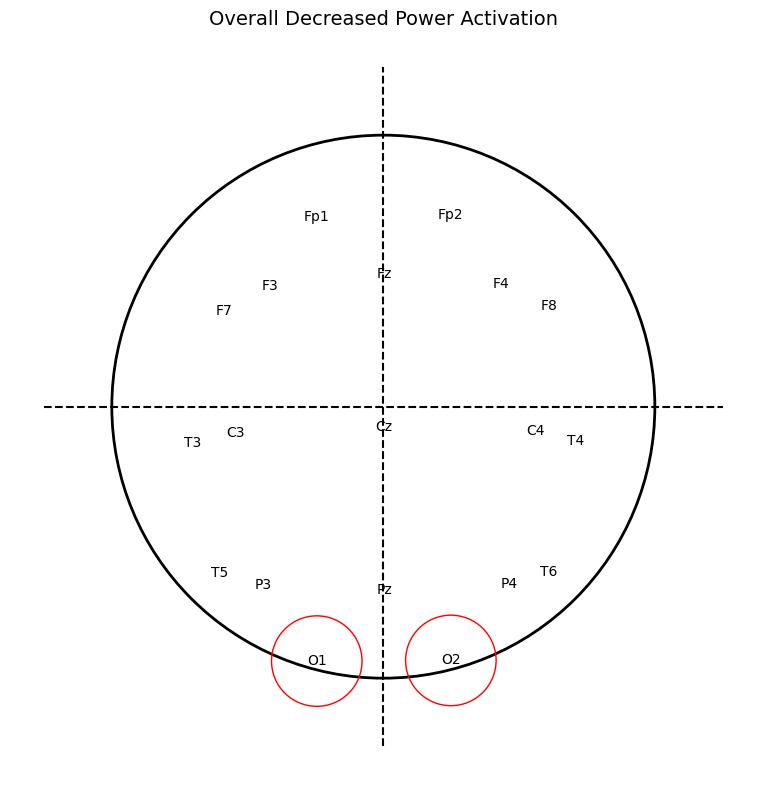

In [ ]:
plot_decreased_activation_plot_overall(cleaned_raw.info['ch_names'], decreased_overall)

[FO1.5] Increased Activation Plot - Overall

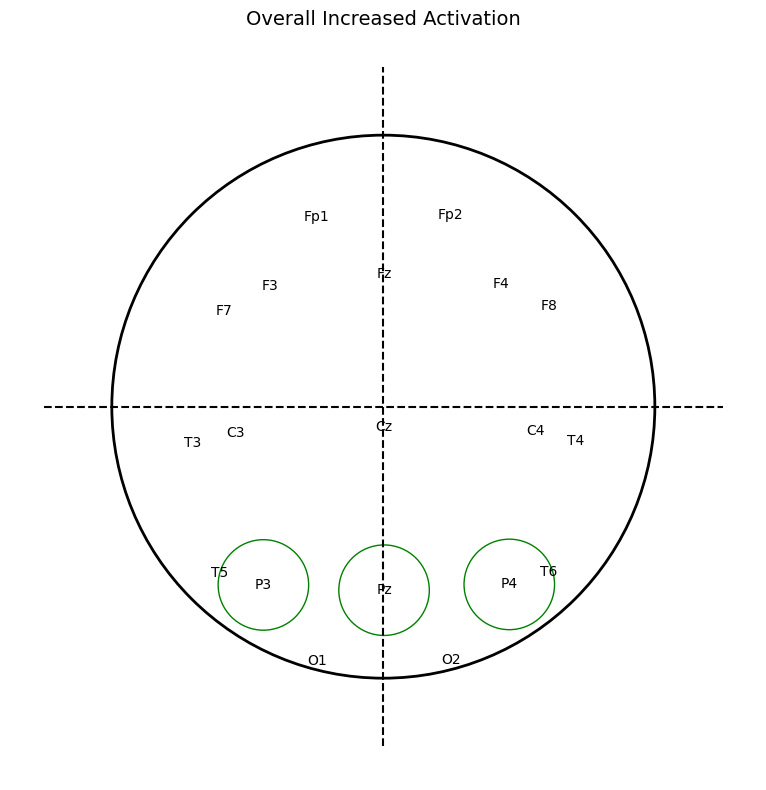

In [ ]:
plot_increased_activation_plot_overall(cleaned_raw.info['ch_names'], increased_overall)

[FO1.6] Decreased Activation Bandwise

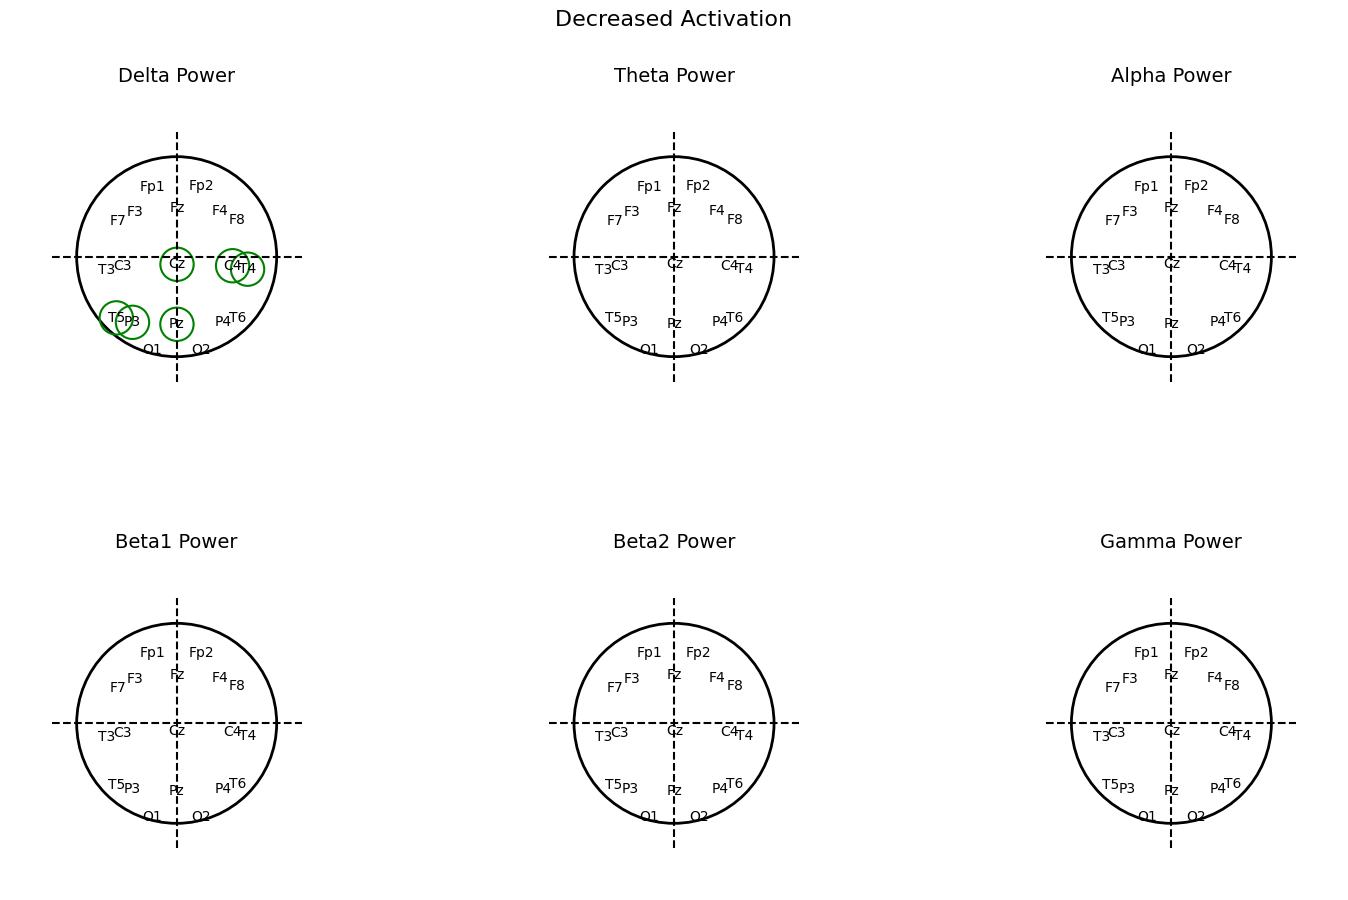

In [ ]:
plot_all_decreased_activations(decreased_electrodes, cleaned_raw.ch_names, report_file_path)

[FO1.7] Increased Activation Bandwise

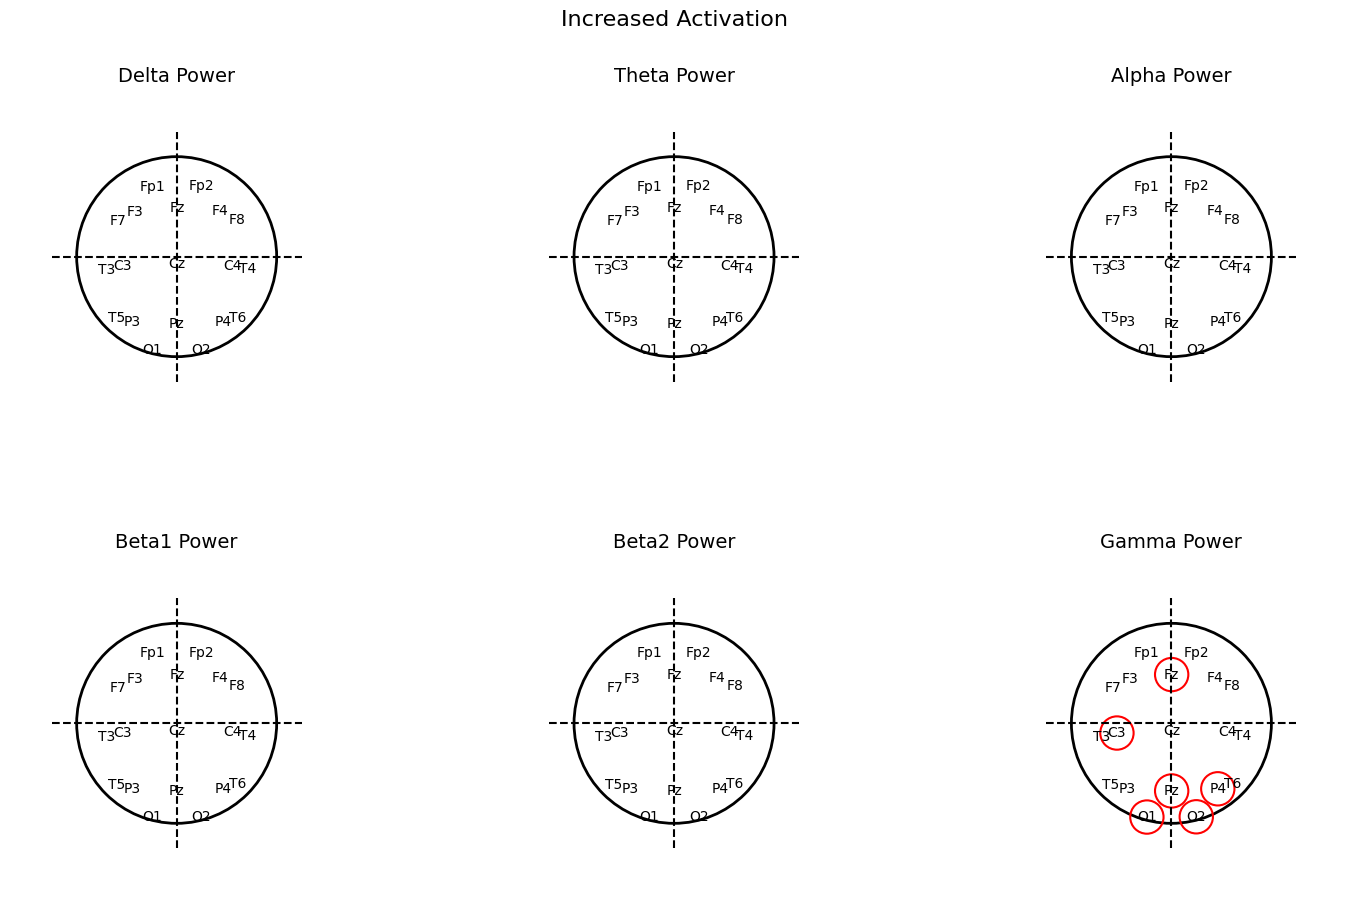

In [ ]:
plot_all_increased_activations(increased_electrodes, cleaned_raw.ch_names, report_file_path)


[FO2] Asymmetry Analysis

In [ ]:
print("\n".join(detailed_summary))

Band: Wide Frequency Range
  No significant asymmetry detected.

Band: Delta
  Significant asymmetry in: Parietal: P3-P4 (Mild AI: 0.112)

Band: Theta
  No significant asymmetry detected.

Band: Alpha
  No significant asymmetry detected.

Band: Beta1
  No significant asymmetry detected.

Band: Beta2
  No significant asymmetry detected.

Band: Gamma
  No significant asymmetry detected.



[FO3] Brodmann Deviation Analysis

In [ ]:
analyze_brodmann_areas_dynamic(
    averaged_deviations,
    brodmann_descriptions,
    dynamic_threshold_percentile=70,
    fixed_threshold=1
)



Top 4 Significant Deviations:
1. Brodmann Area 3, Primary Somatosensory Cortex, Parietal Lobe)
2. Brodmann Area 7, Superior Parietal Lobule, Parietal Lobe)
3. Brodmann Area 4, Primary Motor Cortex, Frontal Lobe)
4. Brodmann Area 45, Pars Triangularis, Frontal Lobe)


# Epileptiform

[FO4.1] OIRDA

In [ ]:
rhythmic_activity = detect_oirda(cleaned_raw)

No significant OIRDA detected.


[FO4.2] FIRDA

In [ ]:
firda_activity = detect_firda(cleaned_raw)

No significant FIRDA detected.


[FO5] Alpha Rhythm Analysis

In [ ]:
alpha_results = analyze_occipital_alpha(cleaned_raw, frequency_bands=frequency_bands)

Occipital Peak Alpha Frequency and Power:
O1: 9.75 Hz / 3.80 µV²
O2: 9.75 Hz / 3.73 µV²


[FO6] Leaky Gut Syndrome Marker

In [ ]:
delta_power_results, final_result = analyze_delta_power(cleaned_raw)

Markers for leaky gut syndrome (slow waves in occipital and temporal regions): No — no significant delta power increase in temporal and occipital regions.


[FO7] Epileptic Spike

In [ ]:
print('Epileptic Spike Analysis')
eeg_analysis_pipeline(cleaned_raw)

Epileptic Spike Analysis

Spikes Analysis:
Count: 9281
Amplitude Mean: 23.71 μV
Peak Amplitude: 73.99 μV
Location Distribution: {'Fp1': '5.27%', 'Fp2': '5.17%', 'F7': '5.17%', 'F3': '5.11%', 'Fz': '5.34%', 'F4': '5.48%', 'F8': '5.45%', 'T3': '5.44%', 'T4': '5.26%', 'T5': '5.28%', 'T6': '5.15%', 'C3': '5.13%', 'Cz': '4.95%', 'C4': '5.15%', 'P3': '5.45%', 'Pz': '5.20%', 'P4': '5.20%', 'O1': '5.31%', 'O2': '5.47%'}
Frequency Characteristics: Delta Band (1-4 Hz)

Sharp Waves Analysis:
Count: 111
Amplitude Mean: 18.98 μV
Peak Amplitude: 36.28 μV
Location Distribution: {'Fp1': '4.50%', 'Fp2': '5.41%', 'F7': '6.31%', 'F3': '9.01%', 'Fz': '6.31%', 'F4': '5.41%', 'F8': '3.60%', 'T3': '2.70%', 'T4': '3.60%', 'T5': '3.60%', 'T6': '3.60%', 'C3': '7.21%', 'Cz': '7.21%', 'C4': '7.21%', 'P3': '2.70%', 'Pz': '5.41%', 'P4': '5.41%', 'O1': '4.50%', 'O2': '6.31%'}
Frequency Characteristics: Theta Band (4-8 Hz)

Generalized Spike-and-Wave Activity (GSW):
Count: 19
Amplitude Mean: 2.2 μV
Peak Amplitude: 2.

[FO8] Theta/Beta1 ratio

Norm2 Theta Power: 1.016188056893573
Norm2 Beta1 Power: 10.456139219897302
Theta/Beta Ratio (Norm2): 0.09718578105385572


(1, 'low', <Figure size 800x600 with 2 Axes>)

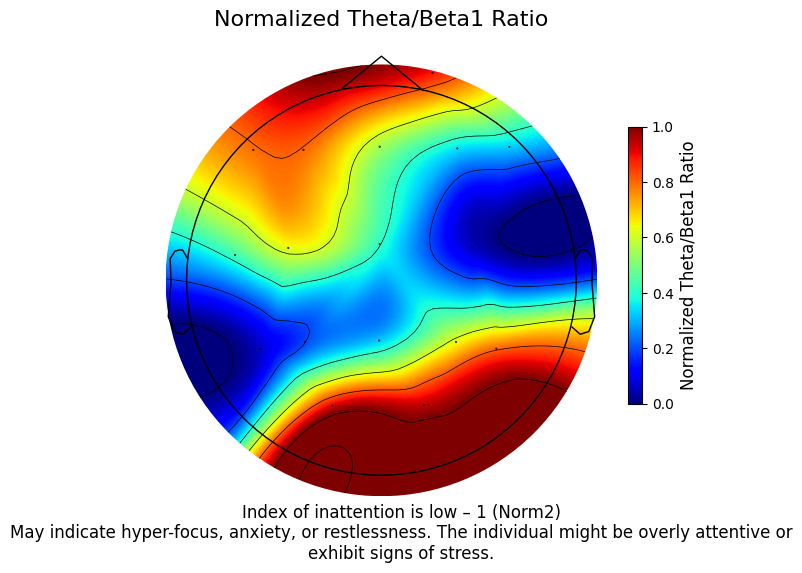

In [ ]:
analyze_theta_beta_ratio_norm2(cleaned_raw, theta_band=frequency_bands['Theta'], beta1_band= frequency_bands['Beta1'],  scaling_factor=10)

[FO9] ADHD

In [ ]:
print(f"ADHD Probability: {results['adhd_probability']:.2f}%")

ADHD Probability: 14.03%


[FO10] Depression

In [ ]:
print(f"Depression Likelihood: {analyze_depression_likelihood(cleaned_raw):.2f}%")

Depression Likelihood: 64.52%


[FO11] Anxiety

In [ ]:
print(f"Anxiety Likelihood: {analyze_anxiety_likelihood(cleaned_raw):.2f}%")

Anxiety Likelihood: 54.00%


[FO12] Autism

In [ ]:
print(f"Autism Likelihood: {compute_autism_likelihood(cleaned_raw):.2f}%")

Autism Likelihood: 40.82%


[FO13] Schizophrenia

In [ ]:
print(f"Schizophrenia Likelihood: {compute_schizophrenia_likelihood(cleaned_raw):.2f}%")

Schizophrenia Likelihood: 67.62%


[FO14] Memory Disorder

In [ ]:
print(f"Cognitive Decline Likelihood: {compute_cognitive_decline_likelihood(cleaned_raw):.2f}%")

Cognitive Decline Likelihood: 29.82%


[FO15] Insomnia

In [ ]:
print(f"Insomnia Likelihood: {compute_insomnia_likelihood(cleaned_raw):.2f}%")

Insomnia Likelihood: 52.34%


[FO16] Dyslexia

In [ ]:
print(f"Dyslexia Likelihood: {compute_dyslexia_likelihood(cleaned_raw):.2f}%")

Dyslexia Likelihood: 43.87%


[FO17] Tinnitus

In [ ]:
print(f"Tinnitus Likelihood: {compute_tinnitus_likelihood(cleaned_raw):.2f}%")

Tinnitus Likelihood: 49.59%


[FO18] OCD

In [ ]:
print(f"OCD Likelihood: {compute_ocd_likelihood(cleaned_raw):.2f}%")

OCD Likelihood: 44.18%


[FO19] Celiac Disease

In [ ]:
print(f"Celiac Likelihood: {compute_celiac_likelihood(cleaned_raw):.2f}%")

Celiac Likelihood: 44.57%
